# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import tempfile
import warnings

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import  Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report, accuracy_score
from imblearn.metrics import classification_report_imbalanced

import zipfile

#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int64  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  int64  
 7   atm             447136 non-null  int64  
 8   col             447136 non-null  int64  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  int64  
 13  prof            447136 non-null  int64  
 14  plan            447136 non-null  int64  
 15  surf            447136 non-null  int64  
 16  infra           447136 non-null  int64  
 17  situ           

Suppression des variables inutiles

In [5]:
df = df.drop(['an','jour', 'grav_rec', 'date', 'dep'], axis=1)

Renumérotation de la variable cible

In [6]:
df['grav'] = df['grav'].replace([1, 2, 3, 4], [0, 1, 2, 3])

# Séparation en train et test

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.412733
3    0.403430
2    0.156550
1    0.027287
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chaque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.412733
3    0.403430
2    0.156549
1    0.027288
Name: proportion, dtype: float64
grav
0    0.412733
3    0.403430
2    0.156552
1    0.027285
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

Normalisation des données

In [10]:
# Normalisation de 'heure' et 'mois' pour X_train et X_test
X_train['heure_sin'] = np.sin(X_train['heure']*(2.*np.pi/24))
X_train['heure_cos'] = np.cos(X_train['heure']*(2.*np.pi/24))

X_train['mois_sin'] = np.sin(X_train['mois']*(2.*np.pi/24))
X_train['mois_cos'] = np.cos(X_train['mois']*(2.*np.pi/24))

X_test['heure_sin'] = np.sin(X_test['heure']*(2.*np.pi/24))
X_test['heure_cos'] = np.cos(X_test['heure']*(2.*np.pi/24))

X_test['mois_sin'] = np.sin(X_test['mois']*(2.*np.pi/24))
X_test['mois_cos'] = np.cos(X_test['mois']*(2.*np.pi/24))

X_train = X_train.drop(['heure', 'mois'], axis = 1)
X_test = X_test.drop(['heure', 'mois'], axis = 1)

In [11]:
# Normalisation de 'lat' et 'long'
scaler1 = RobustScaler()
X_train[['lat', 'long']] = scaler1.fit_transform(X_train[['lat', 'long']])
X_test[['lat', 'long']] = scaler1.transform(X_test[['lat', 'long']])

In [12]:
# Normalisation 'age_usager'
scaler1 = StandardScaler()
X_train[['age_usager']] = scaler1.fit_transform(X_train[['age_usager']])
X_test[['age_usager']] = scaler1.transform(X_test[['age_usager']])

# Construction et entraînement du modèle

### Calbacks

In [13]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 5,
                                        factor = 0.5, 
                                        cooldown = 2,
                                        verbose = 1)

### Modèle 1 : Modèle de base

In [17]:
model1 = Sequential()
model1.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
model1.add(Dense(units = 140, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add( Dense(units = 70, activation = 'relu'))
model1.add(Dense(units = 35, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add(Dense(units = 14, activation = 'relu'))
model1.add(Dense(units = 4, activation = 'softmax'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 70)             │         2,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 140)            │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 70)             │         9,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 14)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,519 (99.68 KB)

 Trainable params: 25,519 (99.68 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model1.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])

In [19]:
history1 = model1.fit(X_train, y_train, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])

Epoch 1/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0010 - sparse_categorical_accuracy: 0.5466 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.6331 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8538 - sparse_categorical_accuracy: 0.6271 - val_loss: 0.8221 - val_sparse_categorical_accuracy: 0.6428 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8295 - sparse_categorical_accuracy: 0.6382 - val_loss: 0.8120 - val_sparse_categorical_accuracy: 0.6469 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8198 - sparse_categorical_accuracy: 0.6413 - val_loss: 0.8061 - val_sparse_categorical_accuracy: 0.6493 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8115 - sparse_categorical_accuracy: 0.6430 - val_loss: 0.8057 - val_sparse_categorical_accuracy: 0.6503 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3

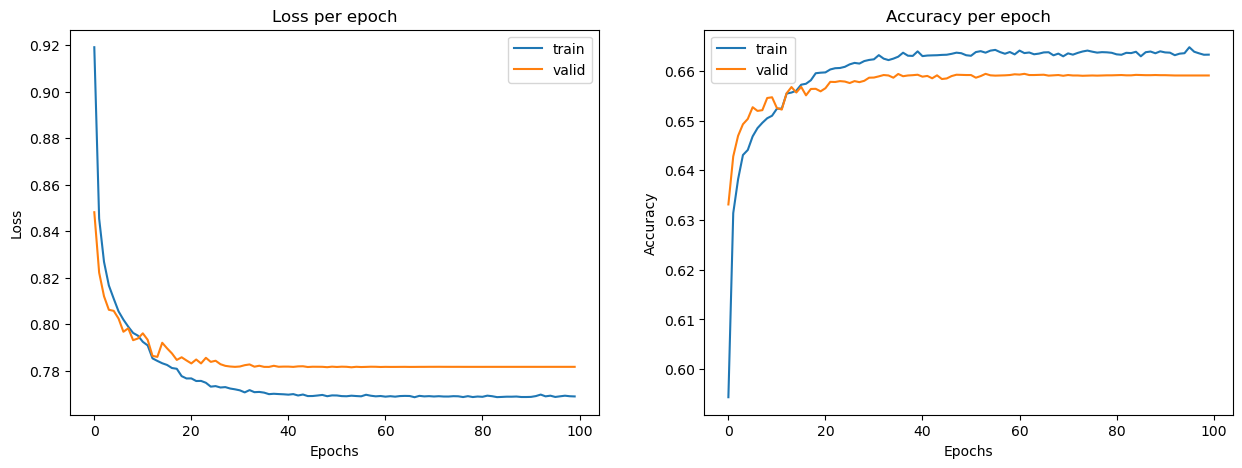

In [20]:
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history1.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history1.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()

In [22]:
test_pred = model1.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
              precision    recall  f1-score   support

           0       0.73      0.80      0.76     46137
           1       0.46      0.05      0.10      3050
           2       0.50      0.39      0.44     17500
           3       0.63      0.65      0.64     45097

    accuracy                           0.66    111784
   macro avg       0.58      0.48      0.49    111784
weighted avg       0.64      0.66      0.64    111784
 




Classe prédite      0    1     2      3
Classe réelle                          
0               37000   14  1249   7874
1                 316  167  1663    904
2                2047  144  6881   8428
3               11561   35  4084  29417



 Accuracy :  66.0


Ne prédit pas correctement les tués.

### Modèle 2 : ajout d'un class_weight

Class_weight généré par keras

In [14]:
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weights_dict = dict(enumerate(weights))
weights_dict

{0: 0.6057177536467477,
 1: 9.161621680690635,
 2: 1.5969447037086422,
 3: 0.6196864536443666}

In [37]:
model2 = Sequential()
model2.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
model2.add(Dense(units = 140, activation = 'relu'))
model2.add(Dropout(rate = 0.2))
model2.add( Dense(units = 70, activation = 'relu'))
model2.add(Dense(units = 35, activation = 'relu'))
model2.add(Dropout(rate = 0.2))
model2.add(Dense(units = 14, activation = 'relu'))
model2.add(Dense(units = 4, activation = 'softmax'))

model2.summary()

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 70)             │         2,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 140)            │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 70)             │         9,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 14)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,519 (99.68 KB)

 Trainable params: 25,519 (99.68 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model2.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])

In [39]:
history2 = model2.fit(X_train, y_train, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)

Epoch 1/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.4466 - val_loss: 1.0612 - val_sparse_categorical_accuracy: 0.5266 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0627 - sparse_categorical_accuracy: 0.5358 - val_loss: 1.0360 - val_sparse_categorical_accuracy: 0.5394 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0361 - sparse_categorical_accuracy: 0.5515 - val_loss: 0.9837 - val_sparse_categorical_accuracy: 0.5618 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0266 - sparse_categorical_accuracy: 0.5562 - val_loss: 0.9565 - val_sparse_categorical_accuracy: 0.5799 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0165 - sparse_categorical_accuracy: 0.5632 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.5850 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2

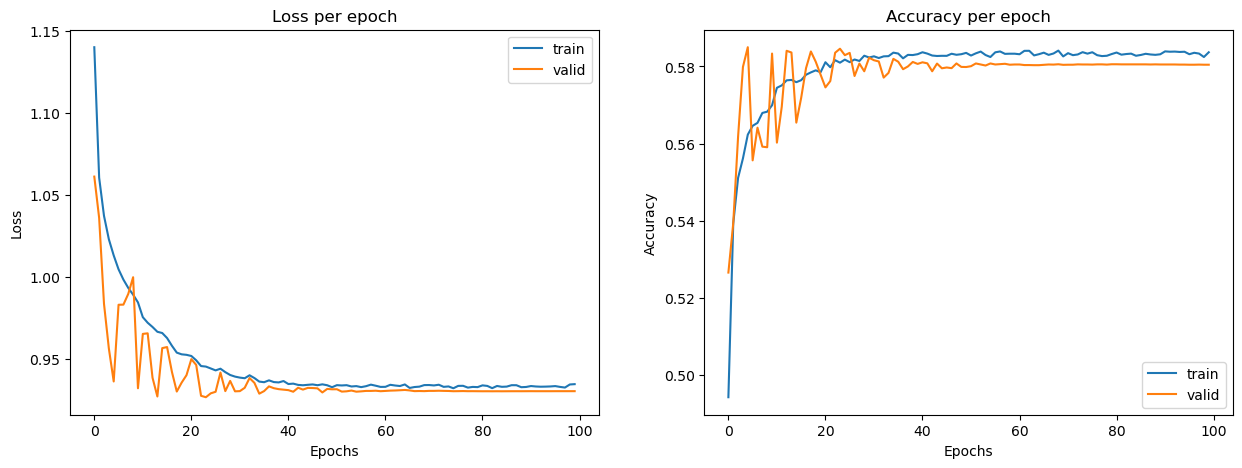

In [40]:
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history2.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()

In [41]:
test_pred = model2.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 230us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.62      0.22      3050
           2       0.37      0.39      0.38     17500
           3       0.68      0.47      0.55     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35458  2256  2377   6046
1                 172  1894   730    254
2                1522  5535  6820   3623
3               10910  4687  8525  20975



 Accuracy :  57.99999999999999


Les résultats sont nettement amélioré par le class_weight.

### Modèle 3 : recherche du meilleur loss

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 621.1550 - sparse_categorical_accuracy: 0.4547 - val_loss: 529.9813 - val_sparse_categorical_accuracy: 0.5293 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 544.9185 - sparse_categorical_accuracy: 0.5344 - val_loss: 502.9749 - val_sparse_categorical_accuracy: 0.5566 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 532.5960 - sparse_categorical_accuracy: 0.5474 - val_loss: 500.2177 - val_sparse_categorical_accuracy: 0.5698 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 521.5770 - sparse_categorical_accuracy: 0.5591 - val_loss: 497.5660 - val_sparse_categorical_accuracy: 0.5627 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 517.1608 - sparse_categorical_accuracy: 0.5625 - val_loss: 501.8562 - val_sparse_categorical_accuracy: 0.5603 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━

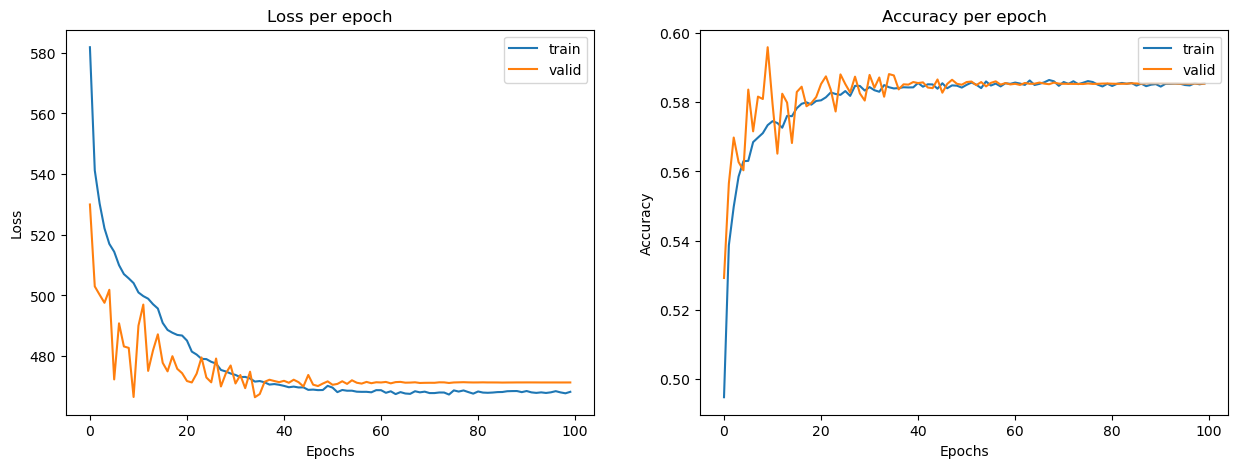

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 301us/step
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     46137
           1       0.13      0.61      0.22      3050
           2       0.37      0.39      0.38     17500
           3       0.67      0.48      0.56     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               34634  2337  2586   6580
1                 148  1864   763    275
2                1396  5435  6848   3821
3               10200  4606  8428  21863



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2203 - sparse_categorical_accuracy: 0.4298 - val_loss: 1.0089 - val_sparse_categorical_accuracy: 0.5364 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0698 - sparse_categorical_accuracy: 0.5282 - val_loss: 0.9936 - val_sparse_categorical_accuracy: 0.5660 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0434 - sparse_categorical_accuracy: 0.5495 - val_loss: 0.9639 - val_sparse_categorical_accuracy: 0.5779 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0238 - sparse_categorical_accuracy: 0.5568 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.5671 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0135 - sparse_categorical_accuracy: 0.5634 - val_loss: 0.9731 - val_sparse_categorical_accuracy: 0.5783 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

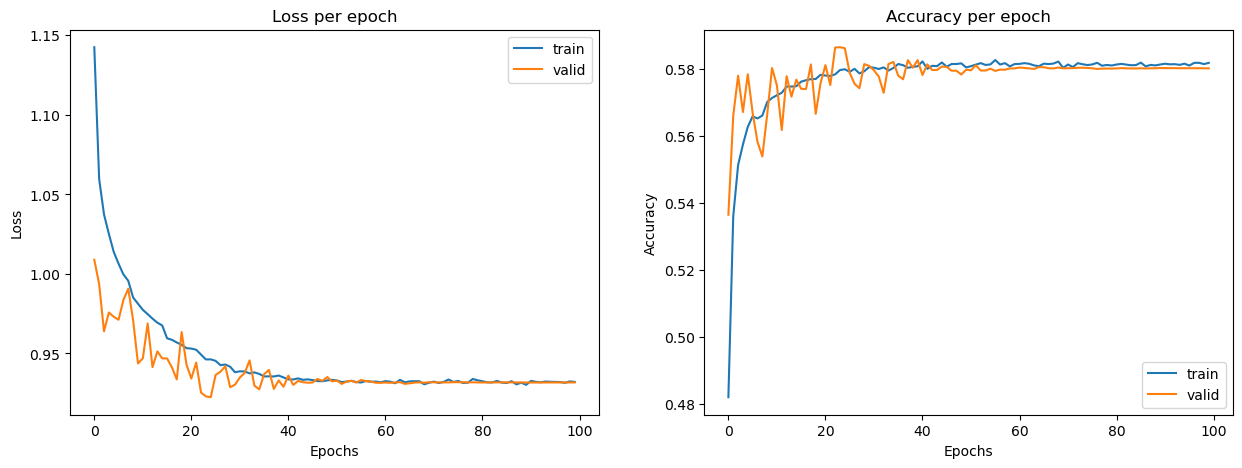

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     46137
           1       0.13      0.63      0.22      3050
           2       0.37      0.40      0.39     17500
           3       0.67      0.47      0.55     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35076  2211  2450   6400
1                 194  1918   700    238
2                1497  5449  7040   3514
3               10648  4660  8813  20976



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2260 - sparse_categorical_accuracy: 0.3907 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.4934 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0656 - sparse_categorical_accuracy: 0.5297 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.5498 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0421 - sparse_categorical_accuracy: 0.5467 - val_loss: 0.9891 - val_sparse_categorical_accuracy: 0.5644 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0286 - sparse_categorical_accuracy: 0.5537 - val_loss: 0.9626 - val_sparse_categorical_accuracy: 0.5794 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0128 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.9785 - val_sparse_categorical_accuracy: 0.5686 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

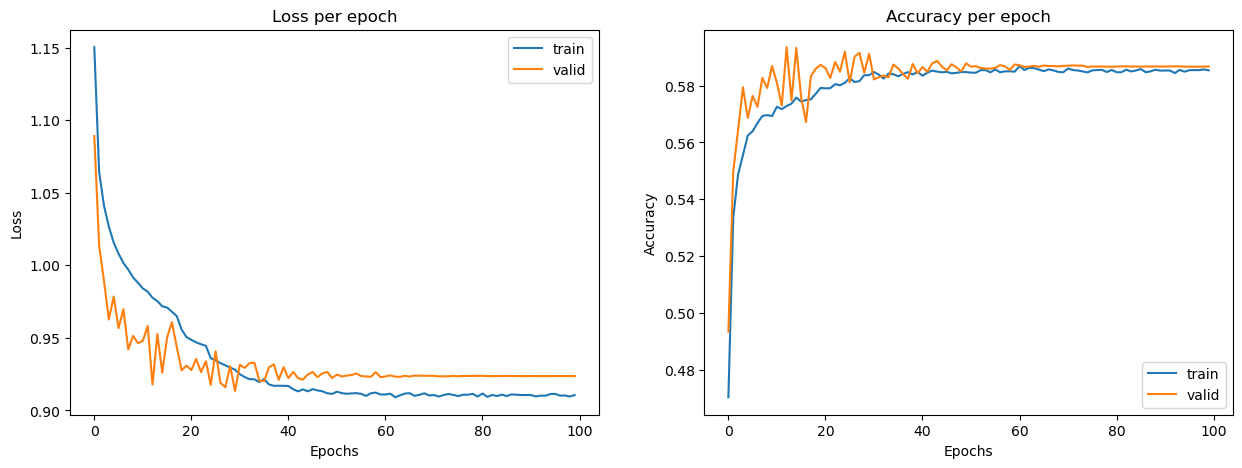

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step
              precision    recall  f1-score   support

           0       0.76      0.73      0.74     46137
           1       0.14      0.60      0.22      3050
           2       0.37      0.40      0.38     17500
           3       0.65      0.51      0.57     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               33521  2169  2682   7765
1                 146  1843   762    299
2                1276  5195  6922   4107
3                9309  4390  8315  23083



 Accuracy :  57.99999999999999


In [80]:
reductions = ["sum", "sum_over_batch_size", None]

for reduction in reductions :
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction = reduction,
        name="sparse_categorical_crossentropy",
    )

    model3 = Sequential()
    model3.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
    model3.add(Dense(units = 140, activation = 'relu'))
    model3.add(Dropout(rate = 0.2))
    model3.add( Dense(units = 70, activation = 'relu'))
    model3.add(Dense(units = 35, activation = 'relu'))
    model3.add(Dropout(rate = 0.2))
    model3.add(Dense(units = 14, activation = 'relu'))
    model3.add(Dense(units = 4, activation = 'softmax'))

    
    model3.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history3 = model3.fit(X_train, y_train, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
    print("\n Loss avec reduction :", reduction)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history3.history['loss'], label = 'train')
    plt.plot(history3.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history3.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history3.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()

    test_pred = model3.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)
    

La meilleure reduction semble être "sum_over_batch_size".

### Modèle 4 : recherche de la meilleure activation

In [81]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.4115 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.5542 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0680 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.9972 - val_sparse_categorical_accuracy: 0.5452 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0485 - sparse_categorical_accuracy: 0.5451 - val_loss: 0.9925 - val_sparse_categorical_accuracy: 0.5488 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.9620 - val_sparse_categorical_accuracy: 0.5747 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0162 - sparse_categorical_accuracy: 0.5608 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.5704 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

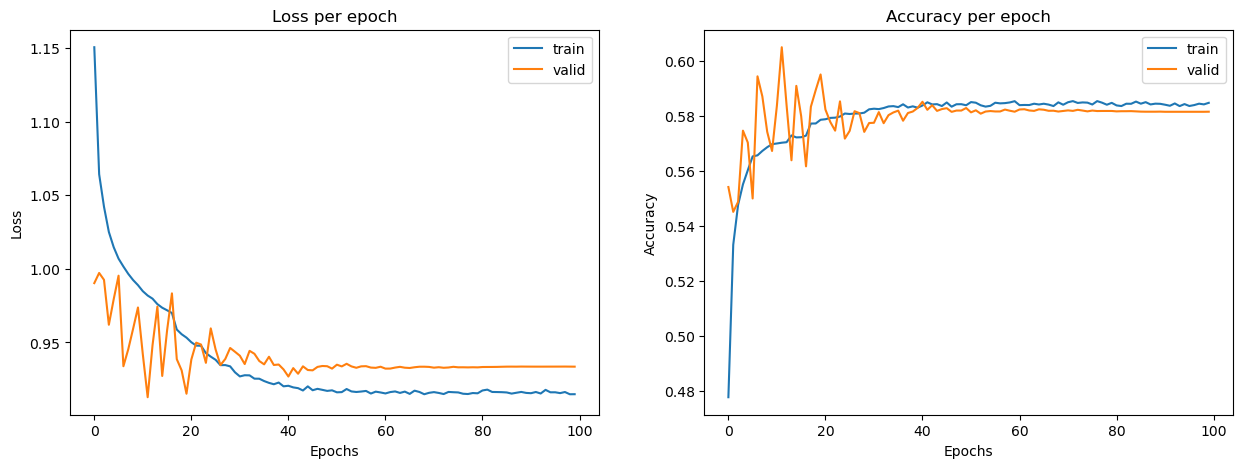

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step
              precision    recall  f1-score   support

           0       0.74      0.75      0.75     46137
           1       0.13      0.63      0.22      3050
           2       0.37      0.40      0.38     17500
           3       0.67      0.48      0.56     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               34802  2286  2572   6477
1                 160  1912   725    253
2                1392  5513  6960   3635
3               10402  4665  8541  21489



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3390 - sparse_categorical_accuracy: 0.3581 - val_loss: 1.1533 - val_sparse_categorical_accuracy: 0.4524 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1337 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.5130 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.1091 - val_sparse_categorical_accuracy: 0.4924 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.5305 - val_loss: 1.0658 - val_sparse_categorical_accuracy: 0.5222 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0775 - sparse_categorical_accuracy: 0.5285 - val_loss: 1.0665 - val_sparse_categorical_accuracy: 0.5149 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

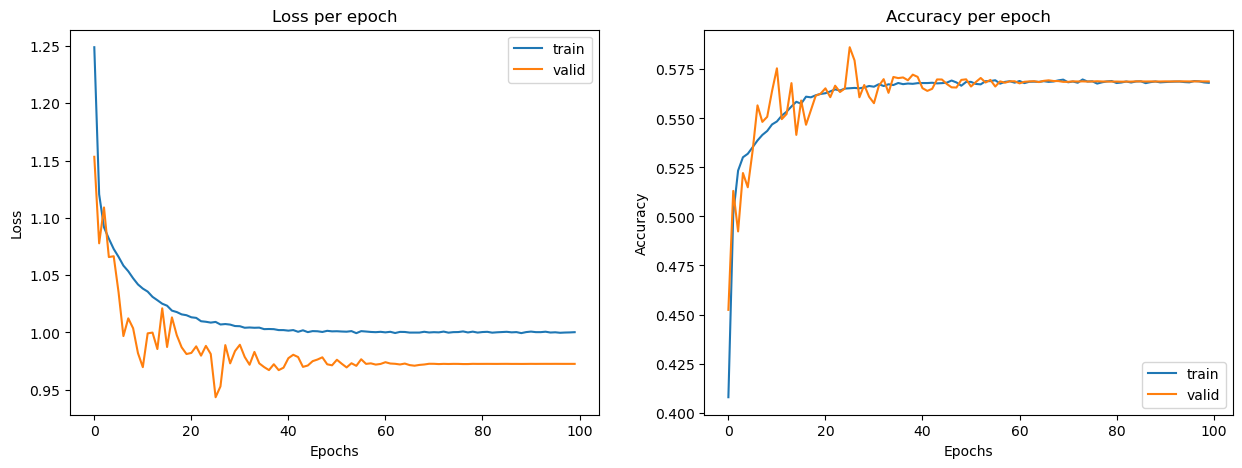

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     46137
           1       0.13      0.65      0.22      3050
           2       0.34      0.32      0.33     17500
           3       0.67      0.44      0.53     45097

    accuracy                           0.57    111784
   macro avg       0.47      0.55      0.46    111784
weighted avg       0.63      0.57      0.58    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36396  2580  1761   5400
1                 208  1977   625    240
2                1716  6150  5653   3981
3               12470  4393  8360  19874



 Accuracy :  56.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1758 - sparse_categorical_accuracy: 0.4708 - val_loss: 1.0676 - val_sparse_categorical_accuracy: 0.5168 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0645 - sparse_categorical_accuracy: 0.5336 - val_loss: 1.0127 - val_sparse_categorical_accuracy: 0.5486 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0516 - sparse_categorical_accuracy: 0.5456 - val_loss: 0.9918 - val_sparse_categorical_accuracy: 0.5576 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0377 - sparse_categorical_accuracy: 0.5514 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.5763 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0303 - sparse_categorical_accuracy: 0.5542 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.5846 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

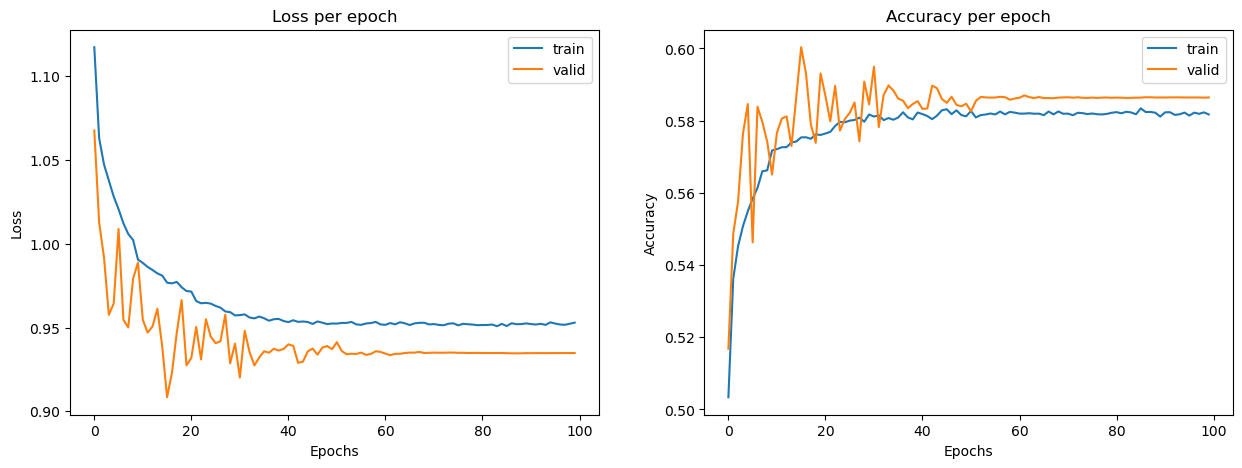

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.13      0.66      0.22      3050
           2       0.37      0.37      0.37     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35674  2230  2335   5898
1                 163  2002   616    269
2                1461  5851  6521   3667
3               11029  4836  8002  21230



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1969 - sparse_categorical_accuracy: 0.4410 - val_loss: 1.0026 - val_sparse_categorical_accuracy: 0.5566 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.0299 - val_sparse_categorical_accuracy: 0.5414 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0379 - sparse_categorical_accuracy: 0.5494 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.5593 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0298 - sparse_categorical_accuracy: 0.5573 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.5507 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0224 - sparse_categorical_accuracy: 0.5560 - val_loss: 0.9971 - val_sparse_categorical_accuracy: 0.5557 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

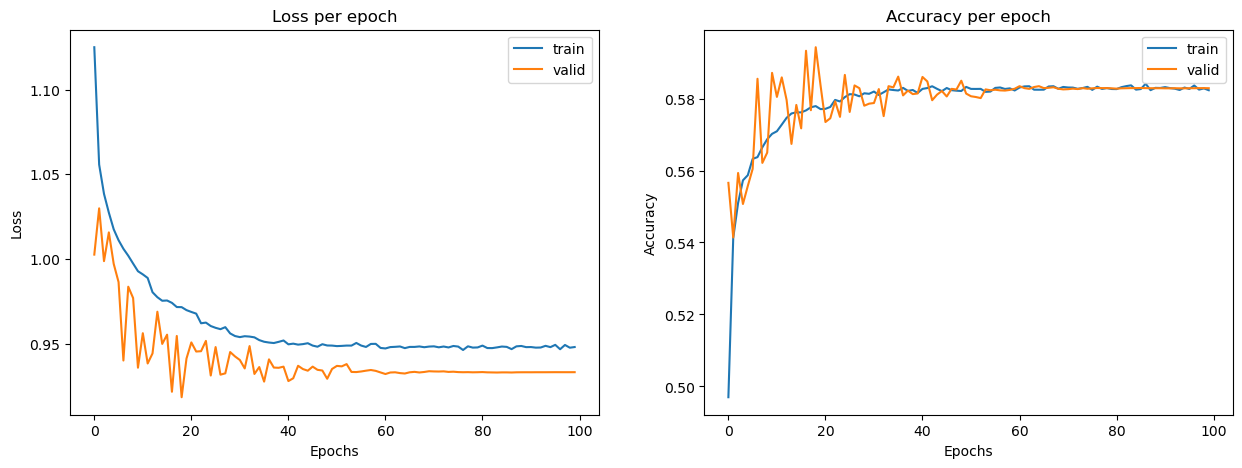

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.65      0.22      3050
           2       0.37      0.37      0.37     17500
           3       0.68      0.47      0.55     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35703  2365  2242   5827
1                 166  1995   655    234
2                1497  5814  6536   3653
3               11143  4856  8100  20998



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1801 - sparse_categorical_accuracy: 0.4729 - val_loss: 1.0212 - val_sparse_categorical_accuracy: 0.5392 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0570 - sparse_categorical_accuracy: 0.5372 - val_loss: 1.0001 - val_sparse_categorical_accuracy: 0.5561 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0363 - sparse_categorical_accuracy: 0.5535 - val_loss: 1.0406 - val_sparse_categorical_accuracy: 0.5270 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0213 - sparse_categorical_accuracy: 0.5577 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.5794 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0104 - sparse_categorical_accuracy: 0.5636 - val_loss: 0.9894 - val_sparse_categorical_accuracy: 0.5640 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

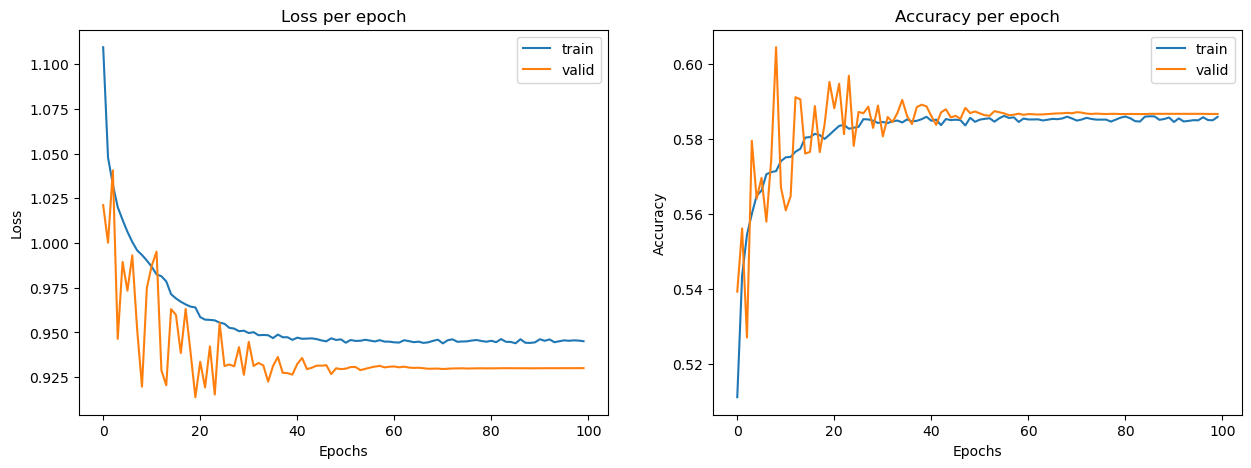

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.13      0.64      0.22      3050
           2       0.38      0.38      0.38     17500
           3       0.69      0.48      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35807  2304  2285   5741
1                 164  1959   663    264
2                1491  5598  6619   3792
3               11033  4694  7905  21465



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1999 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.0349 - val_sparse_categorical_accuracy: 0.5321 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0698 - sparse_categorical_accuracy: 0.5305 - val_loss: 0.9985 - val_sparse_categorical_accuracy: 0.5509 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0451 - sparse_categorical_accuracy: 0.5411 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.5233 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0350 - sparse_categorical_accuracy: 0.5469 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.5653 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0298 - sparse_categorical_accuracy: 0.5519 - val_loss: 0.9763 - val_sparse_categorical_accuracy: 0.5692 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

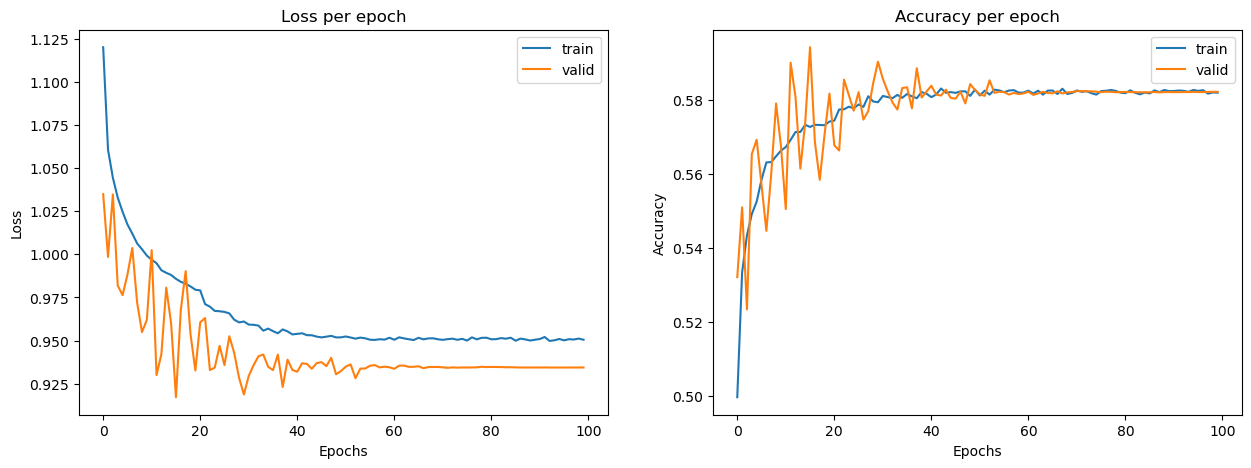

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.13      0.66      0.22      3050
           2       0.37      0.37      0.37     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35684  2312  2333   5808
1                 151  2028   621    250
2                1453  5866  6523   3658
3               11027  4886  8088  21096



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3293 - sparse_categorical_accuracy: 0.4407 - val_loss: 1.0714 - val_sparse_categorical_accuracy: 0.5130 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.0341 - val_sparse_categorical_accuracy: 0.5417 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0666 - sparse_categorical_accuracy: 0.5368 - val_loss: 0.9927 - val_sparse_categorical_accuracy: 0.5573 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0492 - sparse_categorical_accuracy: 0.5438 - val_loss: 1.0805 - val_sparse_categorical_accuracy: 0.5260 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0405 - sparse_categorical_accuracy: 0.5501 - val_loss: 1.0001 - val_sparse_categorical_accuracy: 0.5700 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

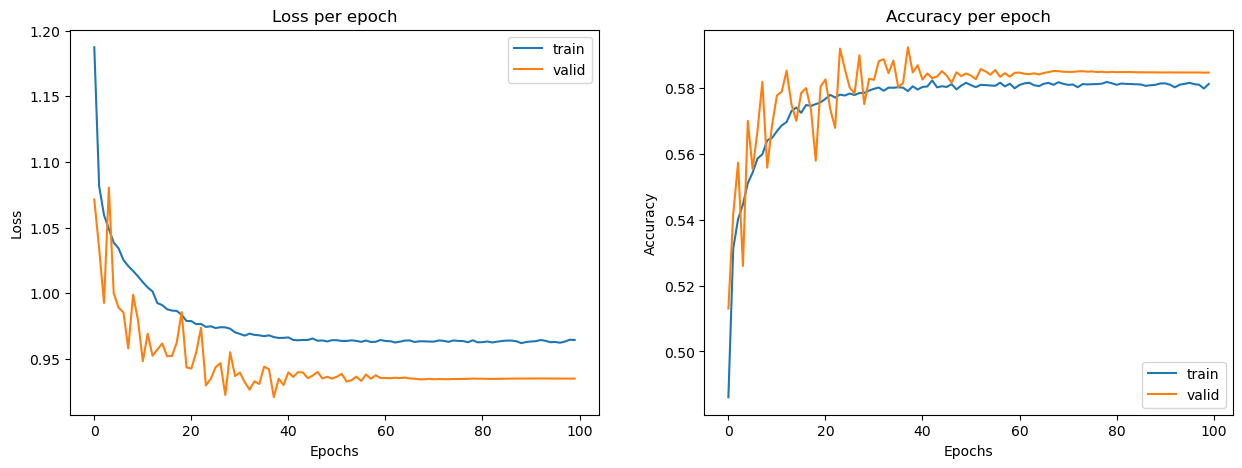

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.14      0.63      0.22      3050
           2       0.37      0.39      0.38     17500
           3       0.68      0.47      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35649  2319  2340   5829
1                 164  1929   723    234
2                1496  5472  6861   3671
3               11105  4555  8393  21044



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1803 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.0404 - val_sparse_categorical_accuracy: 0.5230 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0543 - sparse_categorical_accuracy: 0.5396 - val_loss: 1.0228 - val_sparse_categorical_accuracy: 0.5385 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0279 - sparse_categorical_accuracy: 0.5495 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.5689 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0178 - sparse_categorical_accuracy: 0.5591 - val_loss: 1.0029 - val_sparse_categorical_accuracy: 0.5536 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0051 - sparse_categorical_accuracy: 0.5649 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.6034 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

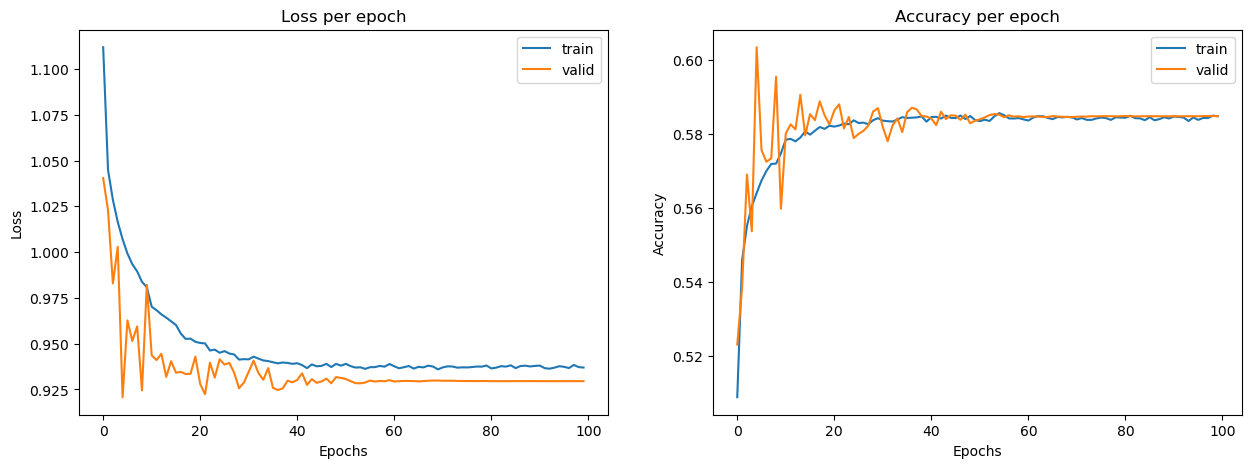

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.13      0.65      0.22      3050
           2       0.38      0.38      0.38     17500
           3       0.69      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.65      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35784  2375  2317   5661
1                 160  1978   662    250
2                1460  5683  6728   3629
3               11039  4855  8152  21051



 Accuracy :  59.0


In [82]:
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'swish', 'elu', 'selu', 'gelu']

for activation in activations :
    model4 = Sequential()
    model4.add( Dense(units = 70, activation = activation, input_shape = (X_train.shape[1],)))
    model4.add(Dense(units = 140, activation = activation))
    model4.add(Dropout(rate = 0.2))
    model4.add( Dense(units = 70, activation = activation))
    model4.add(Dense(units = 35, activation = activation))
    model4.add(Dropout(rate = 0.2))
    model4.add(Dense(units = 14, activation = activation))
    model4.add(Dense(units = 4, activation = 'softmax'))

    model4.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history4 = model4.fit(X_train, y_train, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
    print("\n Modèle avec activation :", activation)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history4.history['loss'], label = 'train')
    plt.plot(history4.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history4.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history4.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model4.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

La meilleure activation est gelu par rapport aux résultats et car il n'y a pas de surrapprentissage.

### Modèle 5 : ajout de kernel_initializer

In [85]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3793.5244 - sparse_categorical_accuracy: 0.2736 - val_loss: 15.5155 - val_sparse_categorical_accuracy: 0.1604 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 26.0549 - sparse_categorical_accuracy: 0.2470 - val_loss: 1.8659 - val_sparse_categorical_accuracy: 0.4114 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.7737 - sparse_categorical_accuracy: 0.2521 - val_loss: 5.2798 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0163 - sparse_categorical_accuracy: 0.2601 - val_loss: 1.9603 - val_sparse_categorical_accuracy: 0.0289 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9500 - sparse_categorical_accuracy: 0.2727 - val_loss: 3.7127 - val_sparse_categorical_accuracy: 0.0283 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━

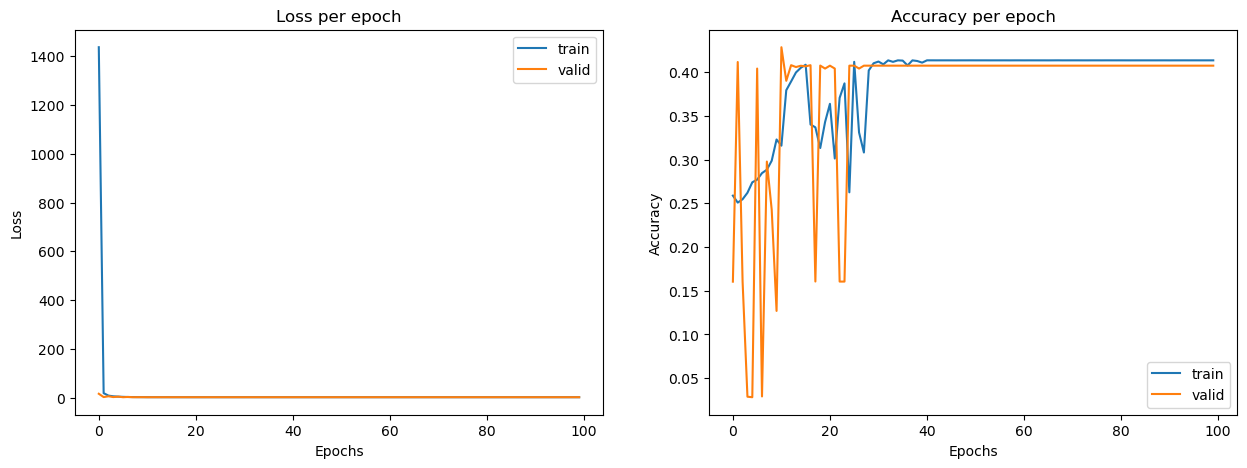

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     46137
           1       0.00      0.00      0.00      3050
           2       0.00      0.00      0.00     17500
           3       0.00      0.00      0.00     45097

    accuracy                           0.41    111784
   macro avg       0.10      0.25      0.15    111784
weighted avg       0.17      0.41      0.24    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0
Classe réelle        
0               46137
1                3050
2               17500
3               45097



 Accuracy :  41.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2268402.0000 - sparse_categorical_accuracy: 0.2772 - val_loss: 28990.2246 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 90188.7344 - sparse_categorical_accuracy: 0.2404 - val_loss: 9402.6885 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17632.9688 - sparse_categorical_accuracy: 0.2397 - val_loss: 6500.0947 - val_sparse_categorical_accuracy: 0.4073 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8013.3687 - sparse_categorical_accuracy: 0.2414 - val_loss: 6577.0889 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6601.7539 - sparse_categorical_accuracy: 0.2429 - val_loss: 12181.8018 - val_sparse_categorical_accuracy: 0.0285 - learning_rate: 0.0010
Epoch 6/100
590/590 

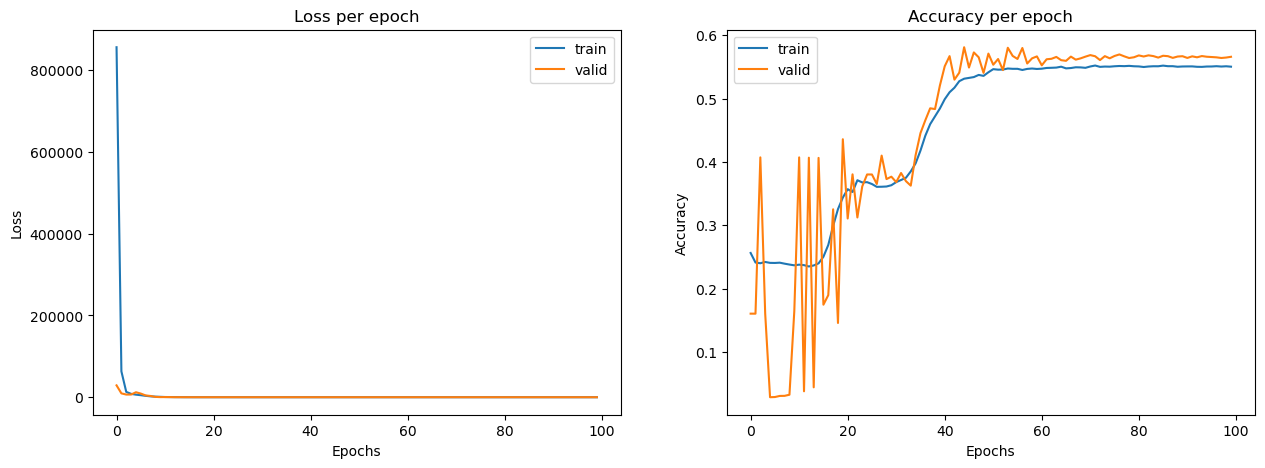

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step
              precision    recall  f1-score   support

           0       0.71      0.76      0.74     46137
           1       0.12      0.65      0.20      3050
           2       0.38      0.26      0.31     17500
           3       0.65      0.49      0.56     45097

    accuracy                           0.57    111784
   macro avg       0.47      0.54      0.45    111784
weighted avg       0.62      0.57      0.58    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35275  3138  1390   6334
1                 194  1975   561    320
2                1649  6211  4560   5080
3               12378  5248  5547  21924



 Accuracy :  56.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1115.0980 - sparse_categorical_accuracy: 0.2485 - val_loss: 1.3822 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 17.5087 - sparse_categorical_accuracy: 0.1771 - val_loss: 1.3870 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.2646 - sparse_categorical_accuracy: 0.1787 - val_loss: 1.3823 - val_sparse_categorical_accuracy: 0.1605 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7068 - sparse_categorical_accuracy: 0.3135 - val_loss: 1.3824 - val_sparse_categorical_accuracy: 0.4073 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0241 - sparse_categorical_accuracy: 0.2991 - val_loss: 1.3838 - val_sparse_categorical_accuracy: 0.4040 - learning_rate: 0.0010
Epoch 6/100
587/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

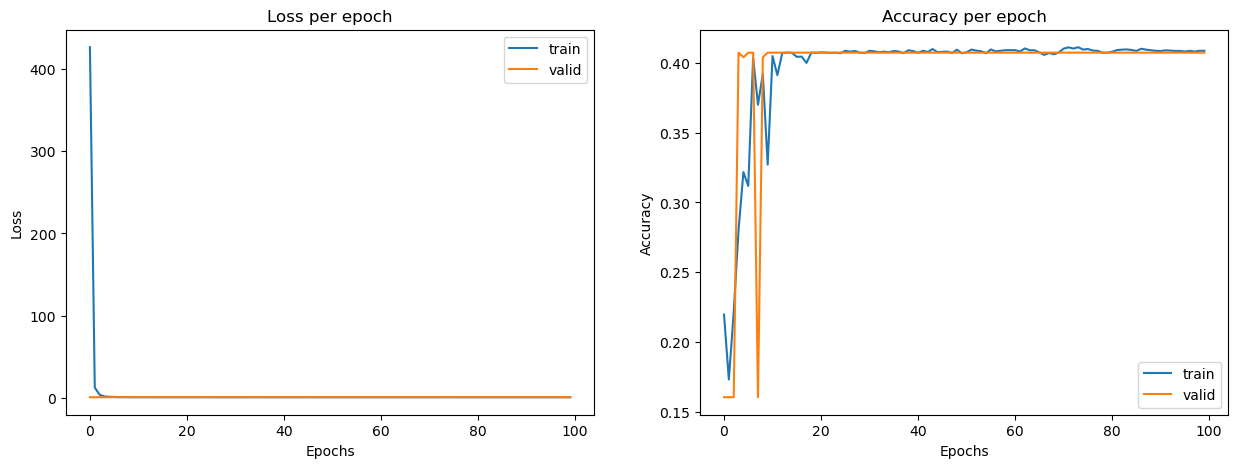

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     46137
           1       0.00      0.00      0.00      3050
           2       0.00      0.00      0.00     17500
           3       0.00      0.00      0.00     45097

    accuracy                           0.41    111784
   macro avg       0.10      0.25      0.15    111784
weighted avg       0.17      0.41      0.24    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0
Classe réelle        
0               46137
1                3050
2               17500
3               45097



 Accuracy :  41.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1915 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.0651 - val_sparse_categorical_accuracy: 0.5214 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0514 - sparse_categorical_accuracy: 0.5410 - val_loss: 0.9989 - val_sparse_categorical_accuracy: 0.5555 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.5575 - val_loss: 0.9754 - val_sparse_categorical_accuracy: 0.5664 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0042 - sparse_categorical_accuracy: 0.5640 - val_loss: 0.9605 - val_sparse_categorical_accuracy: 0.5797 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9964 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.9434 - val_sparse_categorical_accuracy: 0.5793 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

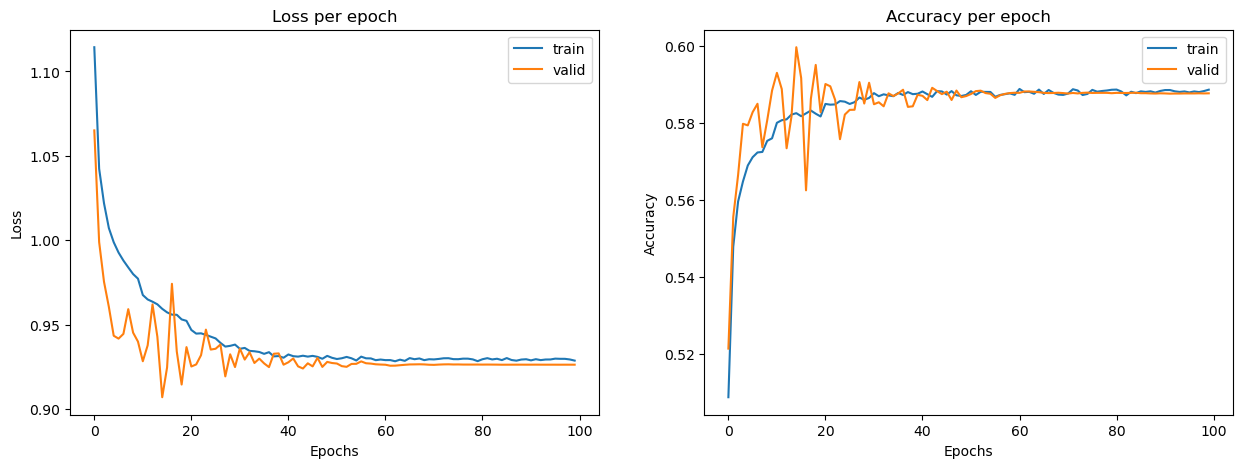

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.62      0.23      3050
           2       0.38      0.41      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35797  2096  2496   5748
1                 172  1893   739    246
2                1466  5290  7168   3576
3               11154  4446  8562  20935



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1936 - sparse_categorical_accuracy: 0.4666 - val_loss: 1.0191 - val_sparse_categorical_accuracy: 0.5398 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0484 - sparse_categorical_accuracy: 0.5459 - val_loss: 0.9797 - val_sparse_categorical_accuracy: 0.5743 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0258 - sparse_categorical_accuracy: 0.5609 - val_loss: 0.9733 - val_sparse_categorical_accuracy: 0.5682 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0160 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.9430 - val_sparse_categorical_accuracy: 0.5847 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0085 - sparse_categorical_accuracy: 0.5654 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.5642 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

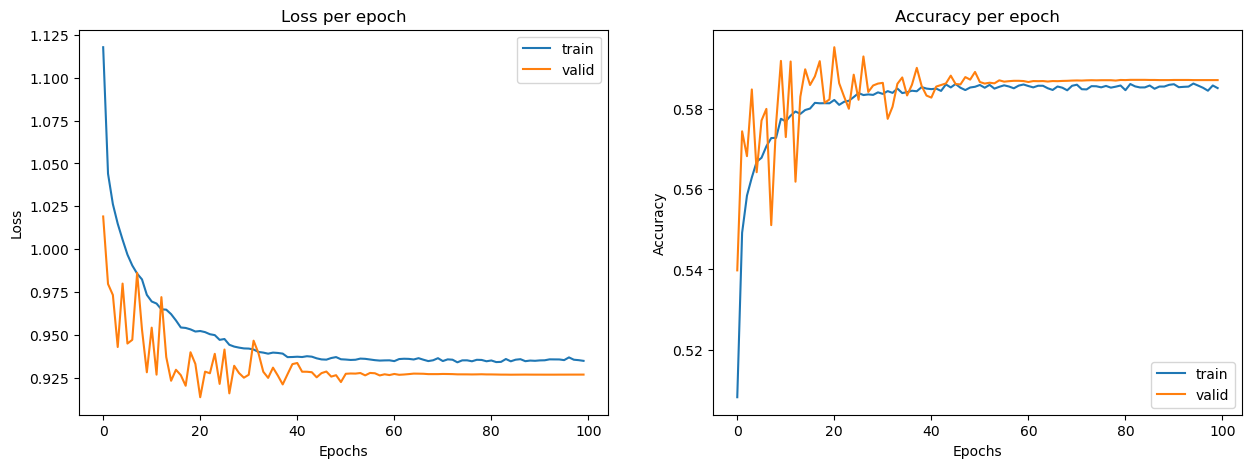

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.63      0.22      3050
           2       0.38      0.40      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36052  2200  2365   5520
1                 165  1920   729    236
2                1528  5439  6937   3596
3               11232  4579  8422  20864



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3967 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.0676 - val_sparse_categorical_accuracy: 0.5219 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0862 - sparse_categorical_accuracy: 0.5182 - val_loss: 1.0087 - val_sparse_categorical_accuracy: 0.5545 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0471 - sparse_categorical_accuracy: 0.5413 - val_loss: 0.9894 - val_sparse_categorical_accuracy: 0.5646 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0336 - sparse_categorical_accuracy: 0.5485 - val_loss: 0.9931 - val_sparse_categorical_accuracy: 0.5650 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0217 - sparse_categorical_accuracy: 0.5574 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.5766 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

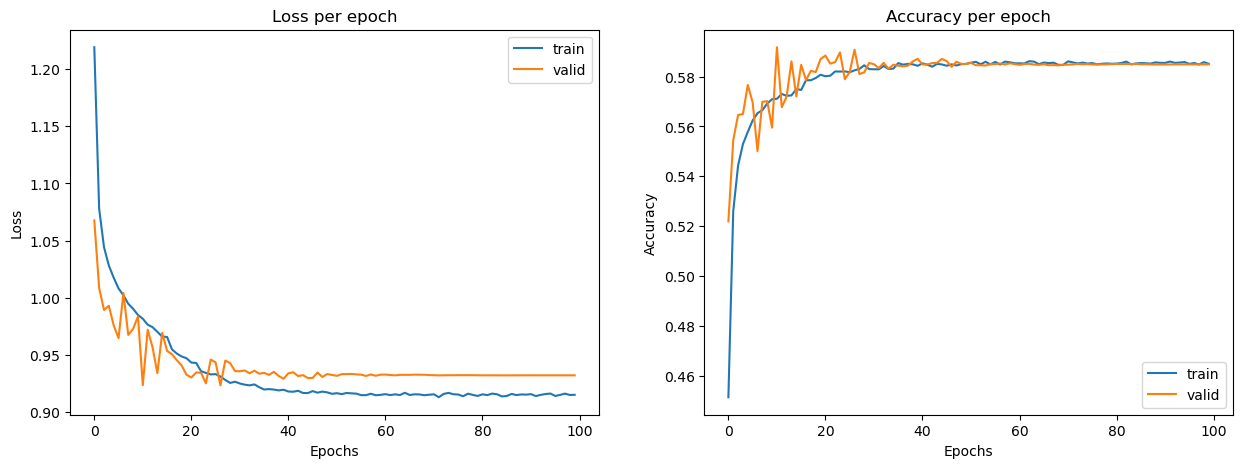

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 302us/step
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     46137
           1       0.14      0.59      0.22      3050
           2       0.37      0.40      0.39     17500
           3       0.66      0.49      0.57     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               34153  1997  2636   7351
1                 165  1812   796    277
2                1416  5186  7085   3813
3                9794  4263  8721  22319



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2457 - sparse_categorical_accuracy: 0.4369 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.5304 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0716 - sparse_categorical_accuracy: 0.5284 - val_loss: 0.9750 - val_sparse_categorical_accuracy: 0.5759 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0463 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.0142 - val_sparse_categorical_accuracy: 0.5481 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0244 - sparse_categorical_accuracy: 0.5530 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.5496 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0147 - sparse_categorical_accuracy: 0.5587 - val_loss: 0.9436 - val_sparse_categorical_accuracy: 0.5781 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

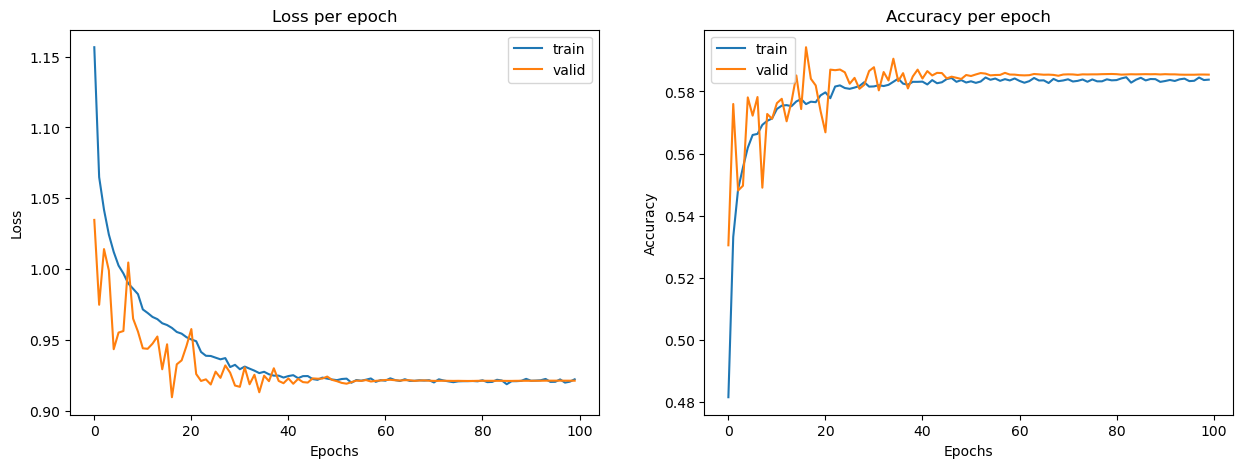

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.61      0.22      3050
           2       0.37      0.39      0.38     17500
           3       0.68      0.48      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35402  2231  2517   5987
1                 162  1866   759    263
2                1497  5332  6899   3772
3               10776  4541  8233  21547



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1768 - sparse_categorical_accuracy: 0.4568 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.5616 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0526 - sparse_categorical_accuracy: 0.5382 - val_loss: 1.0318 - val_sparse_categorical_accuracy: 0.5426 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0347 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.5449 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0136 - sparse_categorical_accuracy: 0.5607 - val_loss: 0.9383 - val_sparse_categorical_accuracy: 0.5892 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0030 - sparse_categorical_accuracy: 0.5677 - val_loss: 0.9982 - val_sparse_categorical_accuracy: 0.5621 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

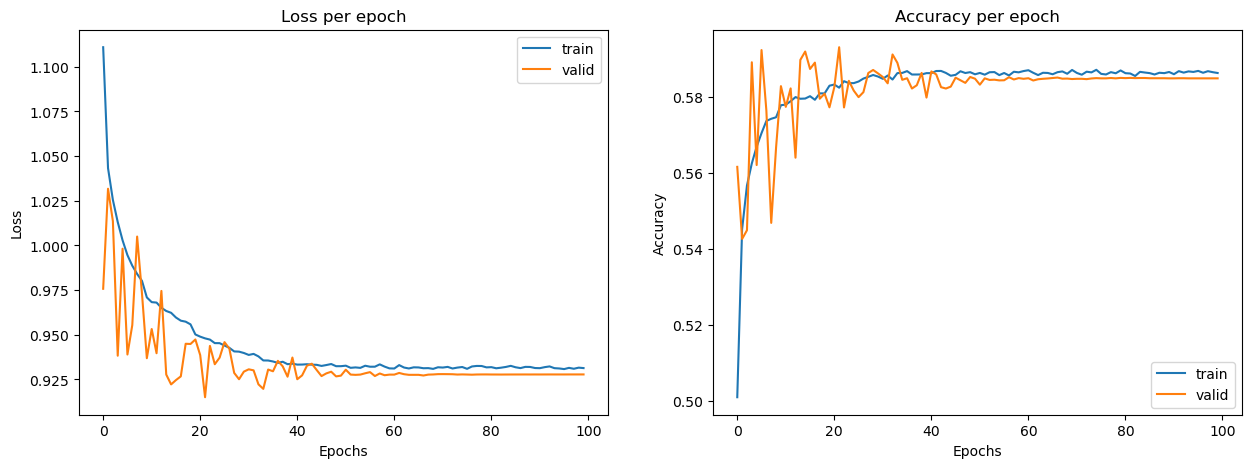

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.13      0.64      0.22      3050
           2       0.38      0.39      0.38     17500
           3       0.69      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.65      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35701  2239  2408   5789
1                 161  1943   709    237
2                1431  5658  6886   3525
3               10926  4689  8324  21158



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.4577 - val_loss: 1.0116 - val_sparse_categorical_accuracy: 0.5591 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0449 - sparse_categorical_accuracy: 0.5424 - val_loss: 0.9664 - val_sparse_categorical_accuracy: 0.5743 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0336 - sparse_categorical_accuracy: 0.5518 - val_loss: 1.0073 - val_sparse_categorical_accuracy: 0.5528 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0159 - sparse_categorical_accuracy: 0.5620 - val_loss: 1.0018 - val_sparse_categorical_accuracy: 0.5575 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0035 - sparse_categorical_accuracy: 0.5649 - val_loss: 0.9512 - val_sparse_categorical_accuracy: 0.5837 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

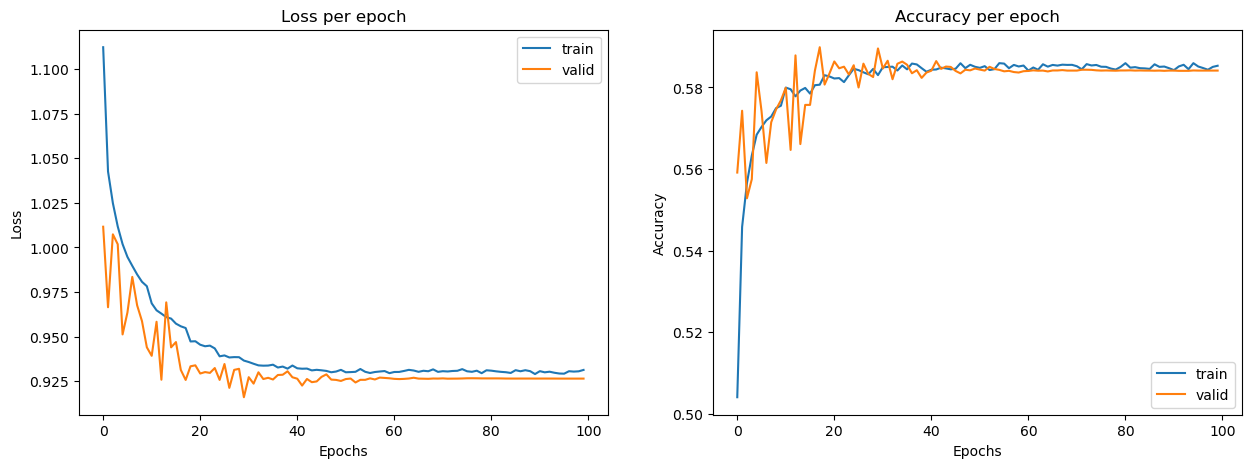

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.13      0.63      0.22      3050
           2       0.37      0.40      0.38     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35834  2212  2494   5597
1                 171  1917   728    234
2                1494  5499  6958   3549
3               11263  4680  8605  20549



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4352 - val_loss: 1.0342 - val_sparse_categorical_accuracy: 0.5313 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0521 - sparse_categorical_accuracy: 0.5390 - val_loss: 1.0327 - val_sparse_categorical_accuracy: 0.5451 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0296 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.0457 - val_sparse_categorical_accuracy: 0.5381 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0183 - sparse_categorical_accuracy: 0.5618 - val_loss: 0.9675 - val_sparse_categorical_accuracy: 0.5762 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0037 - sparse_categorical_accuracy: 0.5671 - val_loss: 0.9620 - val_sparse_categorical_accuracy: 0.5735 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

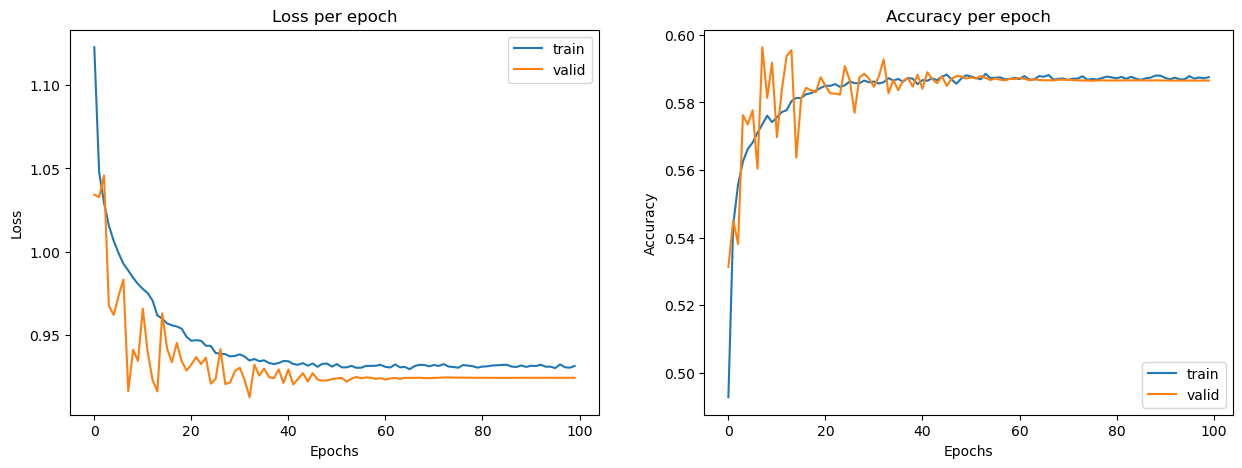

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.63      0.22      3050
           2       0.38      0.39      0.38     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36086  2195  2395   5461
1                 172  1924   718    236
2                1522  5426  6899   3653
3               11298  4620  8333  20846



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4483 - val_loss: 1.0517 - val_sparse_categorical_accuracy: 0.5253 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0530 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.0111 - val_sparse_categorical_accuracy: 0.5370 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0233 - sparse_categorical_accuracy: 0.5515 - val_loss: 0.9902 - val_sparse_categorical_accuracy: 0.5535 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0157 - sparse_categorical_accuracy: 0.5584 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.5564 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0000 - sparse_categorical_accuracy: 0.5624 - val_loss: 0.9247 - val_sparse_categorical_accuracy: 0.5935 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

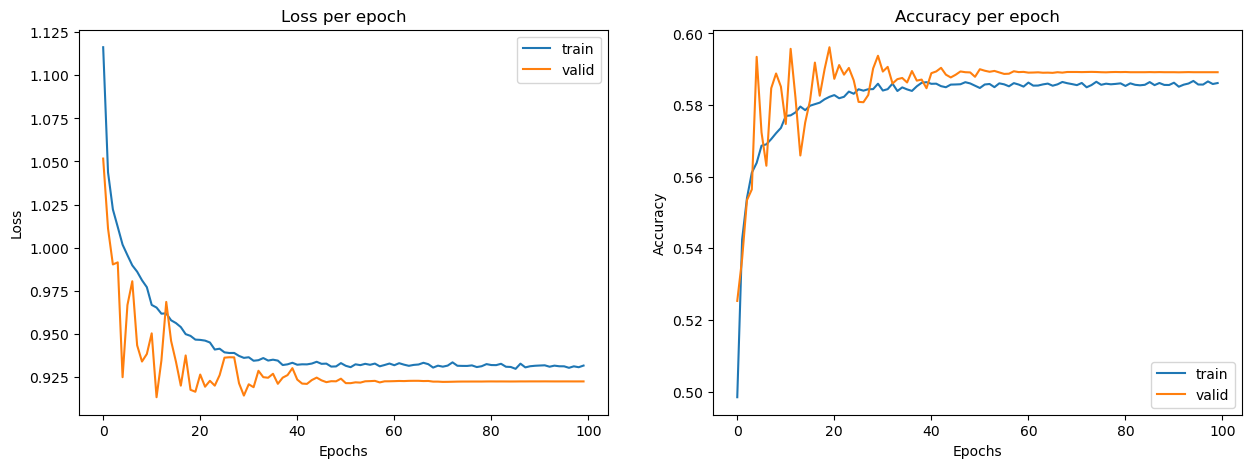

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.62      0.22      3050
           2       0.38      0.40      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35931  2161  2415   5630
1                 168  1898   739    245
2                1500  5379  6973   3648
3               11233  4498  8439  20927



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1779 - sparse_categorical_accuracy: 0.4586 - val_loss: 1.0176 - val_sparse_categorical_accuracy: 0.5451 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0477 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.0155 - val_sparse_categorical_accuracy: 0.5520 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0264 - sparse_categorical_accuracy: 0.5556 - val_loss: 0.9801 - val_sparse_categorical_accuracy: 0.5624 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0086 - sparse_categorical_accuracy: 0.5620 - val_loss: 0.9910 - val_sparse_categorical_accuracy: 0.5521 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9976 - sparse_categorical_accuracy: 0.5655 - val_loss: 0.9575 - val_sparse_categorical_accuracy: 0.5790 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

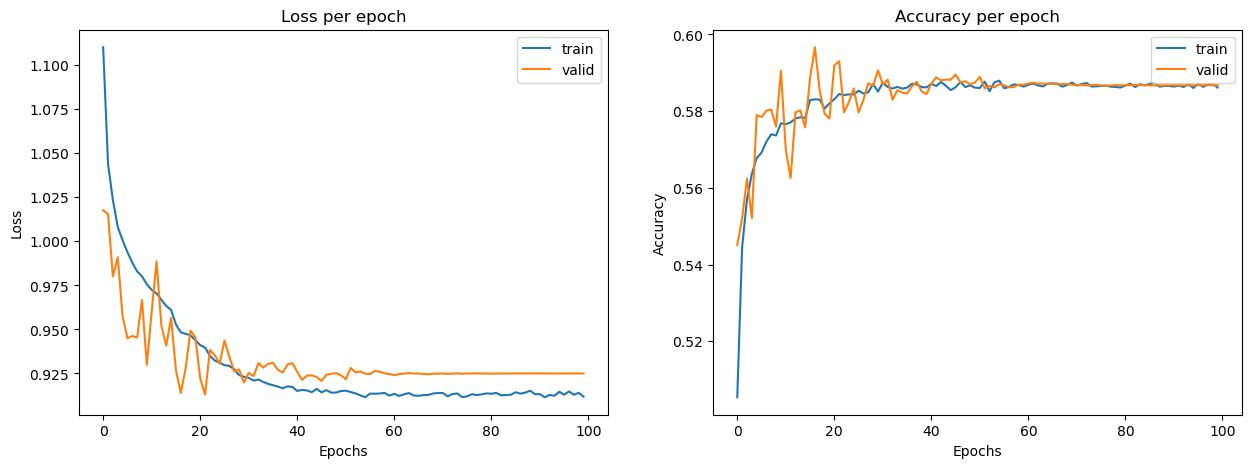

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.62      0.22      3050
           2       0.38      0.40      0.39     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35559  2205  2452   5921
1                 158  1880   761    251
2                1485  5460  6934   3621
3               10882  4628  8307  21280



 Accuracy :  59.0


In [86]:
RandomNormal = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
RandomUniform = tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0)
TruncatedNormal = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
GlorotNormal = tf.keras.initializers.GlorotNormal()
GlorotUniform = tf.keras.initializers.GlorotUniform()
HeNormal = tf.keras.initializers.HeNormal()
HeUniform = tf.keras.initializers.HeUniform()
Orthogonal = tf.keras.initializers.Orthogonal()
VarianceScaling_in = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")
VarianceScaling_out = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_out", distribution="truncated_normal")
LecunNormal = tf.keras.initializers.LecunNormal()
LecunUniform = tf.keras.initializers.LecunUniform()

kernel_initializers = [RandomNormal, 
                       RandomUniform, 
                       TruncatedNormal,
                       GlorotNormal,
                       GlorotUniform,
                       HeNormal,
                       HeUniform,
                       Orthogonal, 
                       VarianceScaling_in, 
                       VarianceScaling_out, 
                       LecunNormal, 
                       LecunUniform]

for kernel_initializer in kernel_initializers :
    model5 = Sequential()
    model5.add( Dense(units = 70, activation = "gelu", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 140, activation = "gelu", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add( Dense(units = 70, activation = "gelu", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 35, activation = "gelu", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add(Dense(units = 14, activation = "gelu", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 4, activation = 'softmax'))

    model5.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history5 = model5.fit(X_train, y_train, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
    print("\n Modèle avec kernel_initializer :", kernel_initializer)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history5.history['loss'], label = 'train')
    plt.plot(history5.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history5.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history5.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model5.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Le meilleur kernel_initializer est GlorotNormal qui maximise le F1 score pour les tués.

### Modèle 6 : choix du nombre de batch

In [87]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.GlorotNormal()

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9432/9432 ━━━━━━━━━━━━━━━━━━━━ 7s 665us/step - loss: 1.1129 - sparse_categorical_accuracy: 0.5110 - val_loss: 1.0114 - val_sparse_categorical_accuracy: 0.5614 - learning_rate: 0.0010
Epoch 2/100
9432/9432 ━━━━━━━━━━━━━━━━━━━━ 6s 623us/step - loss: 1.0262 - sparse_categorical_accuracy: 0.5599 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.5592 - learning_rate: 0.0010
Epoch 3/100
9432/9432 ━━━━━━━━━━━━━━━━━━━━ 6s 610us/step - loss: 1.0060 - sparse_categorical_accuracy: 0.5688 - val_loss: 0.9205 - val_sparse_categorical_accuracy: 0.5852 - learning_rate: 0.0010
Epoch 4/100
9432/9432 ━━━━━━━━━━━━━━━━━━━━ 6s 606us/step - loss: 0.9921 - sparse_categorical_accuracy: 0.5683 - val_loss: 0.9561 - val_sparse_categorical_accuracy: 0.5782 - learning_rate: 0.0010
Epoch 5/100
9432/9432 ━━━━━━━━━━━━━━━━━━━━ 6s 615us/step - loss: 0.9905 - sparse_categorical_accuracy: 0.5692 - val_loss: 0.9898 - val_sparse_categorical_accuracy: 0.5609 - learning_rate: 0.0010
Epoch 6/100
9432/9432 ━━━━━━━━━━━━━━━

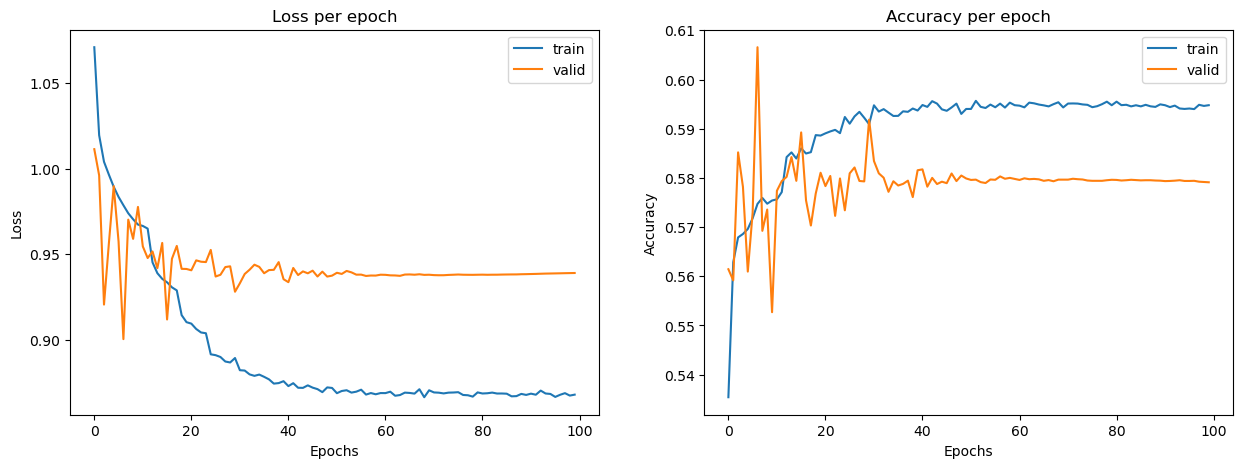

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     46137
           1       0.13      0.58      0.22      3050
           2       0.36      0.45      0.40     17500
           3       0.69      0.45      0.54     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               34881  2069  3141   6046
1                 163  1773   890    224
2                1369  5132  7953   3046
3               10401  4435  9913  20348



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 982us/step - loss: 1.1325 - sparse_categorical_accuracy: 0.4918 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.5345 - learning_rate: 0.0010
Epoch 2/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.0334 - sparse_categorical_accuracy: 0.5563 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.5777 - learning_rate: 0.0010
Epoch 3/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 956us/step - loss: 1.0033 - sparse_categorical_accuracy: 0.5665 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.5643 - learning_rate: 0.0010
Epoch 4/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 958us/step - loss: 0.9941 - sparse_categorical_accuracy: 0.5705 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.5943 - learning_rate: 0.0010
Epoch 5/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 5s 964us/step - loss: 0.9880 - sparse_categorical_accuracy: 0.5748 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.5888 - learning_rate: 0.0010
Epoch 6/100
4716/4716 ━━━━━━━━━━━━━━━━━

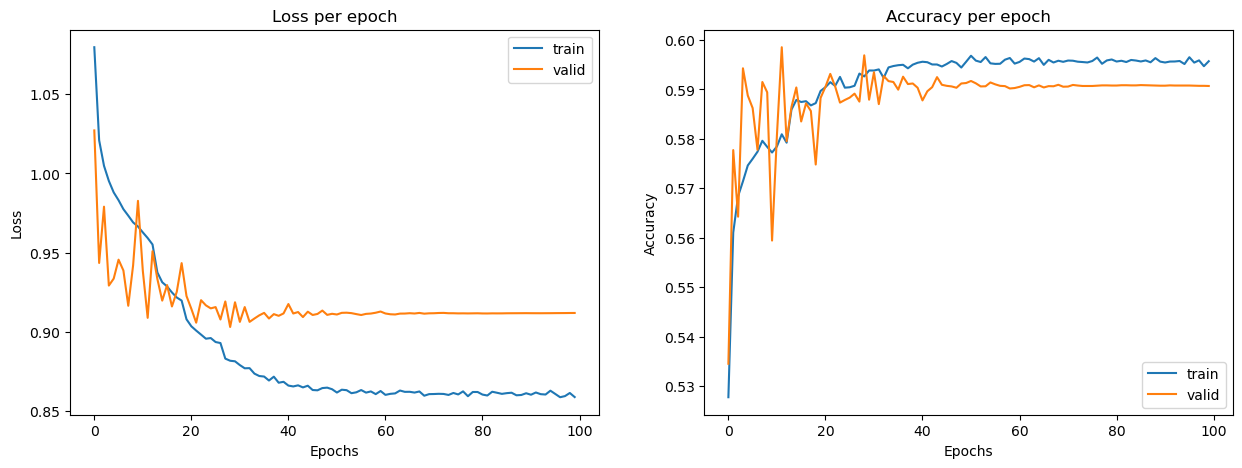

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     46137
           1       0.14      0.55      0.22      3050
           2       0.37      0.46      0.41     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.56      0.49    111784
weighted avg       0.65      0.59      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               34911  1942  2991   6293
1                 175  1691   952    232
2                1389  4724  8075   3312
3               10303  3976  9533  21285



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1301 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.0567 - val_sparse_categorical_accuracy: 0.5247 - learning_rate: 0.0010
Epoch 2/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.0279 - sparse_categorical_accuracy: 0.5530 - val_loss: 0.9721 - val_sparse_categorical_accuracy: 0.5633 - learning_rate: 0.0010
Epoch 3/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0137 - sparse_categorical_accuracy: 0.5609 - val_loss: 1.0449 - val_sparse_categorical_accuracy: 0.5356 - learning_rate: 0.0010
Epoch 4/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0019 - sparse_categorical_accuracy: 0.5661 - val_loss: 0.9378 - val_sparse_categorical_accuracy: 0.5762 - learning_rate: 0.0010
Epoch 5/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9906 - sparse_categorical_accuracy: 0.5712 - val_loss: 0.9374 - val_sparse_categorical_accuracy: 0.5777 - learning_rate: 0.0010
Epoch 6/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2

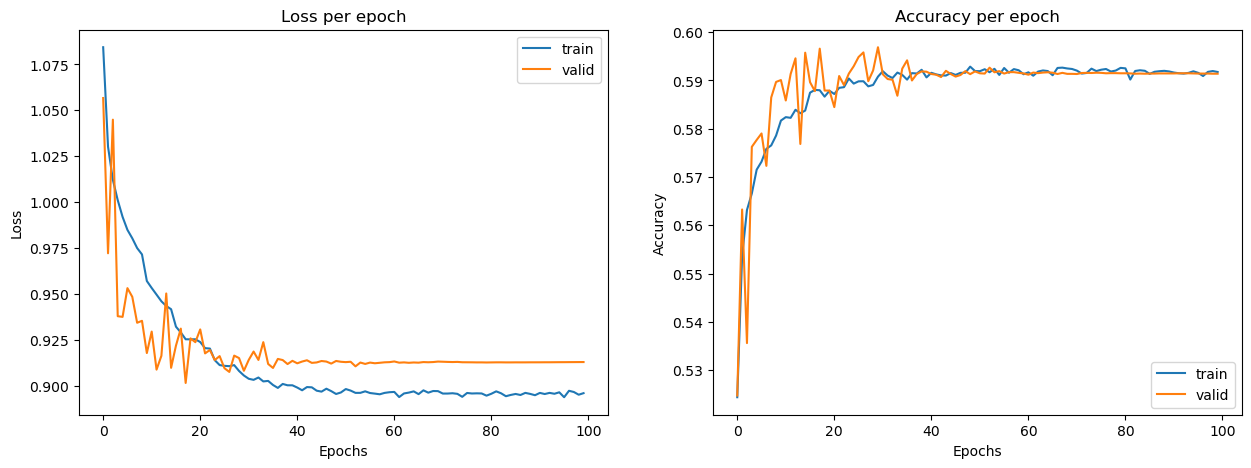

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.59      0.22      3050
           2       0.38      0.43      0.40     17500
           3       0.69      0.46      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.57      0.48    111784
weighted avg       0.65      0.59      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35755  2046  2694   5642
1                 160  1796   843    251
2                1489  5094  7602   3315
3               10987  4184  9046  20880



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.4901 - val_loss: 0.9913 - val_sparse_categorical_accuracy: 0.5684 - learning_rate: 0.0010
Epoch 2/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0408 - sparse_categorical_accuracy: 0.5504 - val_loss: 0.9962 - val_sparse_categorical_accuracy: 0.5503 - learning_rate: 0.0010
Epoch 3/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0187 - sparse_categorical_accuracy: 0.5620 - val_loss: 0.9974 - val_sparse_categorical_accuracy: 0.5576 - learning_rate: 0.0010
Epoch 4/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0117 - sparse_categorical_accuracy: 0.5663 - val_loss: 0.9502 - val_sparse_categorical_accuracy: 0.5799 - learning_rate: 0.0010
Epoch 5/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9961 - sparse_categorical_accuracy: 0.5713 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.5549 - learning_rate: 0.0010
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2

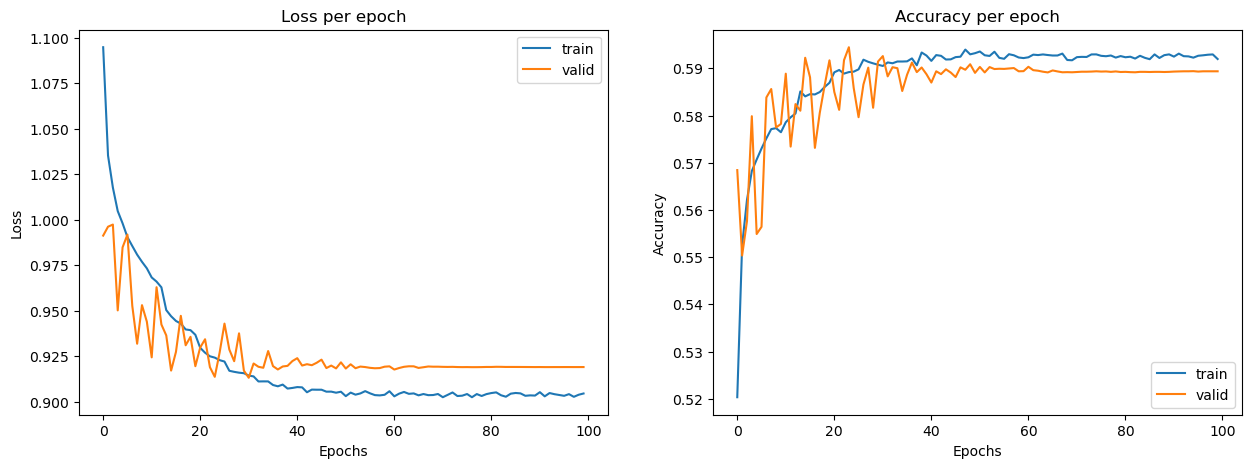

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.61      0.22      3050
           2       0.38      0.42      0.40     17500
           3       0.70      0.46      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.57      0.48    111784
weighted avg       0.65      0.59      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35930  2147  2503   5557
1                 170  1848   790    242
2                1487  5284  7367   3362
3               11099  4315  8762  20921



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.4283 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.5481 - learning_rate: 0.0010
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0544 - sparse_categorical_accuracy: 0.5428 - val_loss: 0.9773 - val_sparse_categorical_accuracy: 0.5721 - learning_rate: 0.0010
Epoch 3/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.5571 - val_loss: 0.9727 - val_sparse_categorical_accuracy: 0.5730 - learning_rate: 0.0010
Epoch 4/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0182 - sparse_categorical_accuracy: 0.5625 - val_loss: 0.9679 - val_sparse_categorical_accuracy: 0.5639 - learning_rate: 0.0010
Epoch 5/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0068 - sparse_categorical_accuracy: 0.5677 - val_loss: 0.9598 - val_sparse_categorical_accuracy: 0.5808 - learning_rate: 0.0010
Epoch 6/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

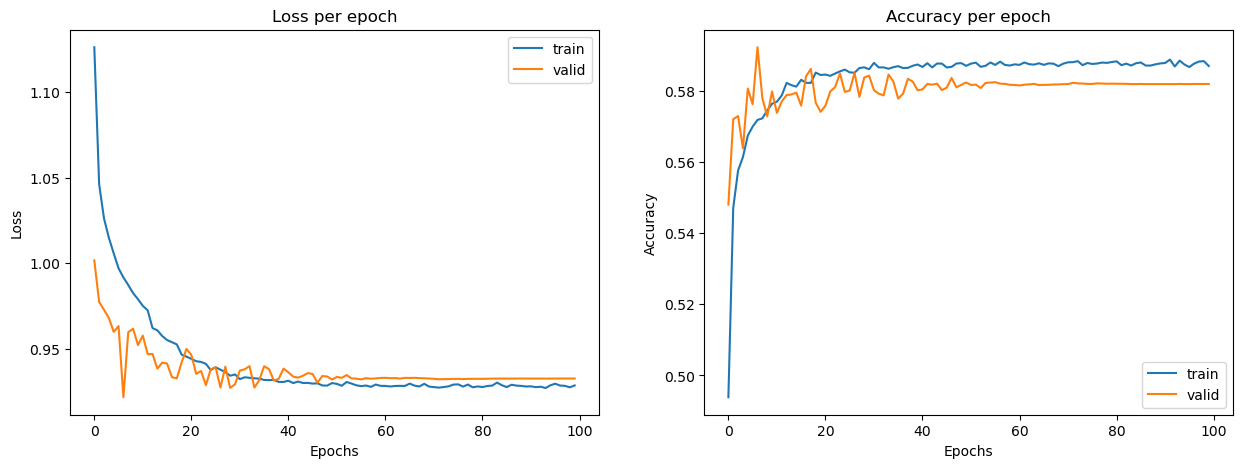

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.13      0.63      0.22      3050
           2       0.37      0.40      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35770  2313  2382   5672
1                 156  1922   722    250
2                1511  5550  6962   3477
3               11046  4571  8575  20905



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2284 - sparse_categorical_accuracy: 0.4372 - val_loss: 1.0469 - val_sparse_categorical_accuracy: 0.5264 - learning_rate: 0.0010
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0605 - sparse_categorical_accuracy: 0.5347 - val_loss: 1.0202 - val_sparse_categorical_accuracy: 0.5453 - learning_rate: 0.0010
Epoch 3/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0321 - sparse_categorical_accuracy: 0.5479 - val_loss: 0.9965 - val_sparse_categorical_accuracy: 0.5612 - learning_rate: 0.0010
Epoch 4/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0222 - sparse_categorical_accuracy: 0.5591 - val_loss: 0.9994 - val_sparse_categorical_accuracy: 0.5650 - learning_rate: 0.0010
Epoch 5/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0149 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.0168 - val_sparse_categorical_accuracy: 0.5485 - learning_rate: 0.0010
Epoch 6/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

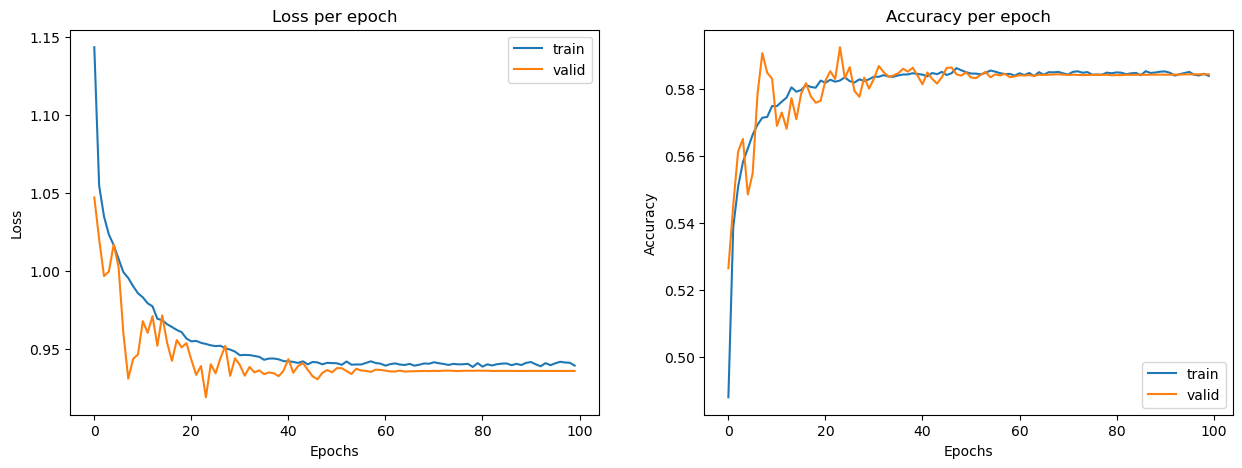

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.13      0.65      0.22      3050
           2       0.37      0.38      0.38     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35823  2382  2364   5568
1                 157  1982   674    237
2                1466  5736  6655   3643
3               11147  4797  8212  20941



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2669 - sparse_categorical_accuracy: 0.4178 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.5397 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0801 - sparse_categorical_accuracy: 0.5243 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0494 - sparse_categorical_accuracy: 0.5446 - val_loss: 1.0062 - val_sparse_categorical_accuracy: 0.5505 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0311 - sparse_categorical_accuracy: 0.5515 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.5705 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0227 - sparse_categorical_accuracy: 0.5566 - val_loss: 0.9853 - val_sparse_categorical_accuracy: 0.5655 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

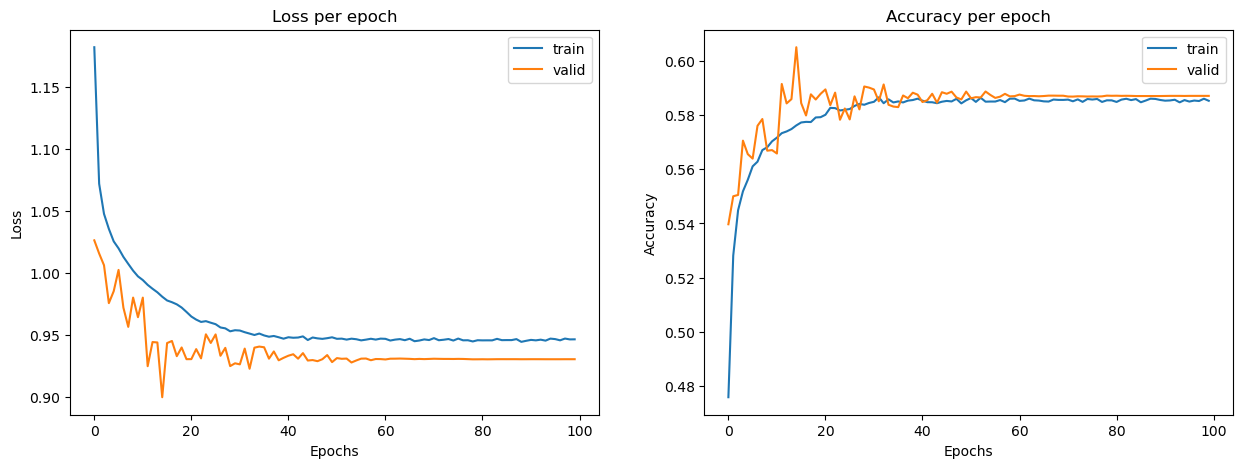

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.65      0.22      3050
           2       0.38      0.38      0.38     17500
           3       0.68      0.48      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35586  2329  2305   5917
1                 155  1969   658    268
2                1468  5605  6613   3814
3               10875  4636  7927  21659



 Accuracy :  59.0


In [88]:
batchs = [32, 64, 128, 256, 512, 1024, 2048]

for batch in batchs :
    model6 = Sequential()
    model6.add( Dense(units = 70, activation = "gelu", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 140, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add( Dense(units = 70, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 35, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add(Dense(units = 14, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 4, activation = 'softmax'))

    model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history6 = model6.fit(X_train, y_train, epochs = 100, batch_size = batch, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
    print("\n Modèle avec batch_size de :", batch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history6.history['loss'], label = 'train')
    plt.plot(history6.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model6.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Le batch qui a les meilleurs résulats est donc un batch de 128.

### Modèle 6 : choix du nombre d'epochs

In [89]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.GlorotNormal()

Epoch 1/10


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1557 - sparse_categorical_accuracy: 0.4713 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.5861 - learning_rate: 0.0010
Epoch 2/10
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0362 - sparse_categorical_accuracy: 0.5536 - val_loss: 1.0243 - val_sparse_categorical_accuracy: 0.5387 - learning_rate: 0.0010
Epoch 3/10
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0128 - sparse_categorical_accuracy: 0.5621 - val_loss: 0.9756 - val_sparse_categorical_accuracy: 0.5636 - learning_rate: 0.0010
Epoch 4/10
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0022 - sparse_categorical_accuracy: 0.5696 - val_loss: 0.9403 - val_sparse_categorical_accuracy: 0.5844 - learning_rate: 0.0010
Epoch 5/10
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9983 - sparse_categorical_accuracy: 0.5727 - val_loss: 0.9626 - val_sparse_categorical_accuracy: 0.5721 - learning_rate: 0.0010
Epoch 6/10
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

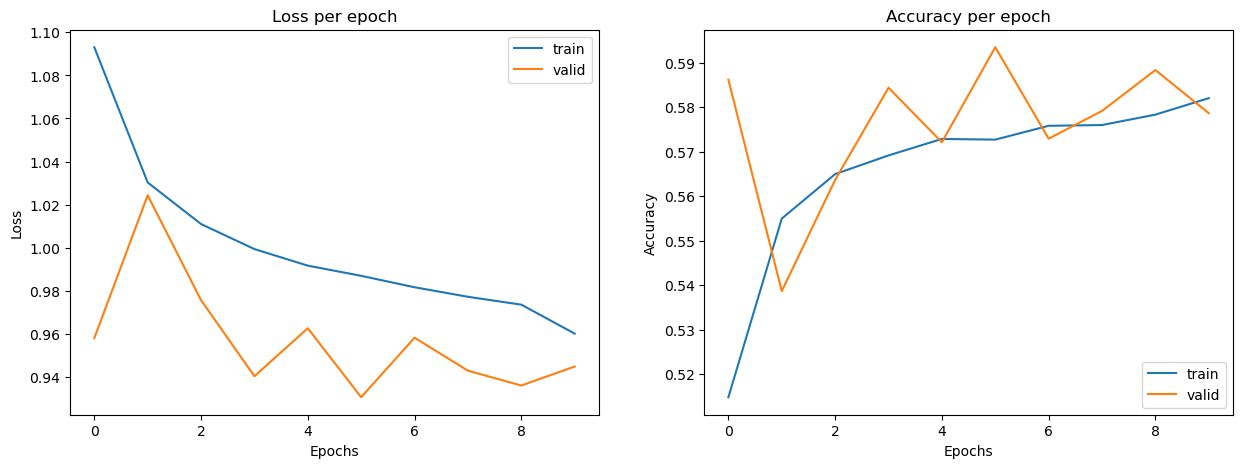

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.63      0.22      3050
           2       0.36      0.41      0.38     17500
           3       0.69      0.45      0.54     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35756  2412  2774   5195
1                 159  1910   744    237
2                1438  5426  7209   3427
3               11199  4396  9349  20153



 Accuracy :  57.99999999999999
Epoch 1/20


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1388 - sparse_categorical_accuracy: 0.4913 - val_loss: 0.9811 - val_sparse_categorical_accuracy: 0.5668 - learning_rate: 0.0010
Epoch 2/20
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0318 - sparse_categorical_accuracy: 0.5543 - val_loss: 0.9700 - val_sparse_categorical_accuracy: 0.5702 - learning_rate: 0.0010
Epoch 3/20
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0100 - sparse_categorical_accuracy: 0.5665 - val_loss: 0.9858 - val_sparse_categorical_accuracy: 0.5496 - learning_rate: 0.0010
Epoch 4/20
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9987 - sparse_categorical_accuracy: 0.5699 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.5902 - learning_rate: 0.0010
Epoch 5/20
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9893 - sparse_categorical_accuracy: 0.5738 - val_loss: 0.9156 - val_sparse_categorical_accuracy: 0.5969 - learning_rate: 0.0010
Epoch 6/20
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

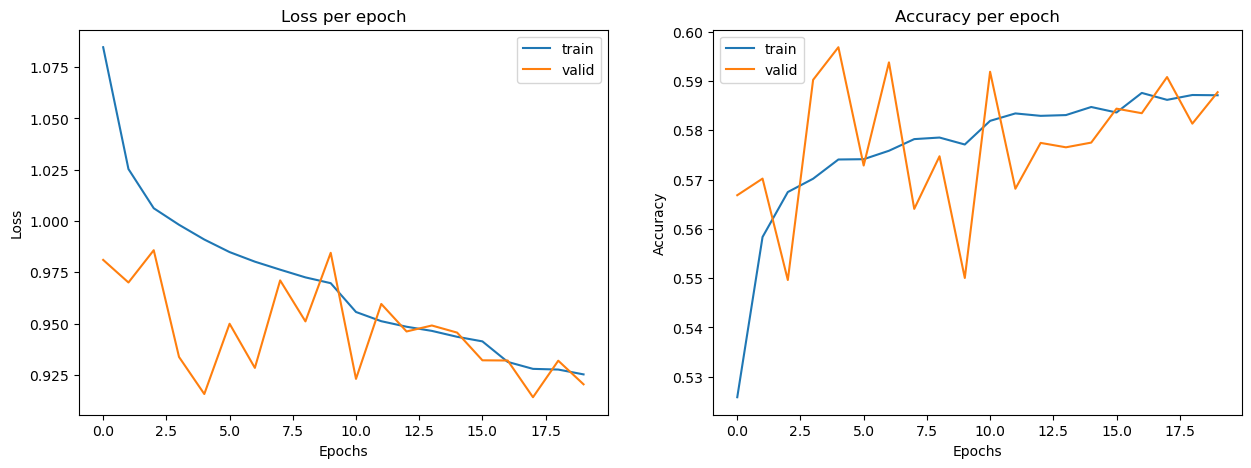

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.14      0.59      0.23      3050
           2       0.37      0.43      0.39     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35440  1826  2813   6058
1                 172  1808   830    240
2                1433  5219  7449   3399
3               10712  4111  9214  21060



 Accuracy :  59.0
Epoch 1/30


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.4852 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.5497 - learning_rate: 0.0010
Epoch 2/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0351 - sparse_categorical_accuracy: 0.5518 - val_loss: 0.9583 - val_sparse_categorical_accuracy: 0.5754 - learning_rate: 0.0010
Epoch 3/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0056 - sparse_categorical_accuracy: 0.5678 - val_loss: 0.9932 - val_sparse_categorical_accuracy: 0.5449 - learning_rate: 0.0010
Epoch 4/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9982 - sparse_categorical_accuracy: 0.5670 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.5704 - learning_rate: 0.0010
Epoch 5/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9885 - sparse_categorical_accuracy: 0.5742 - val_loss: 0.9668 - val_sparse_categorical_accuracy: 0.5726 - learning_rate: 0.0010
Epoch 6/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

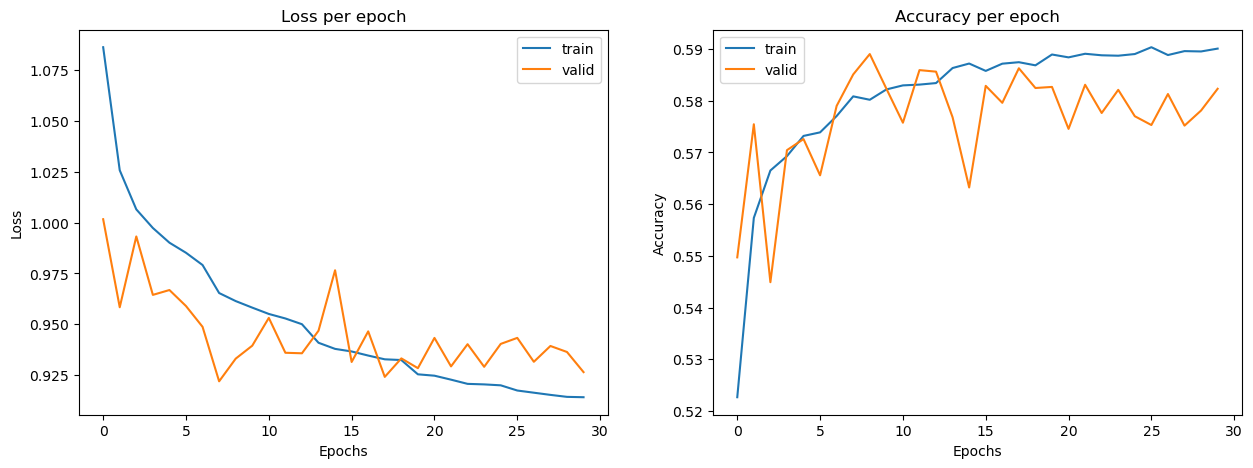

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.62      0.22      3050
           2       0.38      0.42      0.40     17500
           3       0.69      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.65      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35305  2323  2498   6011
1                 156  1887   781    226
2                1429  5592  7294   3185
3               10559  4698  8853  20987



 Accuracy :  59.0
Epoch 1/40


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 901s 382ms/step - loss: 1.1363 - sparse_categorical_accuracy: 0.5017 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.5752 - learning_rate: 0.0010
Epoch 2/40
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0358 - sparse_categorical_accuracy: 0.5570 - val_loss: 0.9513 - val_sparse_categorical_accuracy: 0.5773 - learning_rate: 0.0010
Epoch 3/40
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 243s 103ms/step - loss: 1.0072 - sparse_categorical_accuracy: 0.5647 - val_loss: 0.9447 - val_sparse_categorical_accuracy: 0.5829 - learning_rate: 0.0010
Epoch 4/40
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0022 - sparse_categorical_accuracy: 0.5684 - val_loss: 0.9730 - val_sparse_categorical_accuracy: 0.5647 - learning_rate: 0.0010
Epoch 5/40
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 1081s 459ms/step - loss: 0.9936 - sparse_categorical_accuracy: 0.5741 - val_loss: 0.9432 - val_sparse_categorical_accuracy: 0.5972 - learning_rate: 0.0010
Epoch 6/40
2358/2358 ━━━━━━━━━━━━━━━━━

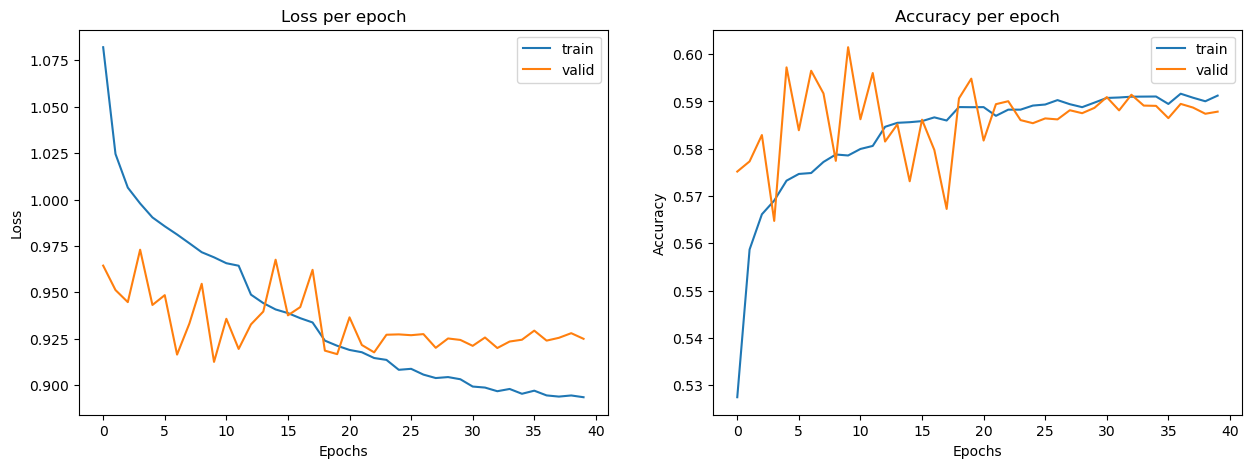

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.59      0.23      3050
           2       0.37      0.43      0.40     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35769  2021  2667   5680
1                 172  1801   843    234
2                1545  5006  7563   3386
3               11029  4127  9294  20647



 Accuracy :  59.0
Epoch 1/50


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1353 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.0112 - val_sparse_categorical_accuracy: 0.5450 - learning_rate: 0.0010
Epoch 2/50
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.0324 - sparse_categorical_accuracy: 0.5498 - val_loss: 0.9686 - val_sparse_categorical_accuracy: 0.5747 - learning_rate: 0.0010
Epoch 3/50
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0063 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.9930 - val_sparse_categorical_accuracy: 0.5615 - learning_rate: 0.0010
Epoch 4/50
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9983 - sparse_categorical_accuracy: 0.5677 - val_loss: 0.9564 - val_sparse_categorical_accuracy: 0.5828 - learning_rate: 0.0010
Epoch 5/50
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.9959 - sparse_categorical_accuracy: 0.5722 - val_loss: 0.9728 - val_sparse_categorical_accuracy: 0.5640 - learning_rate: 0.0010
Epoch 6/50
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

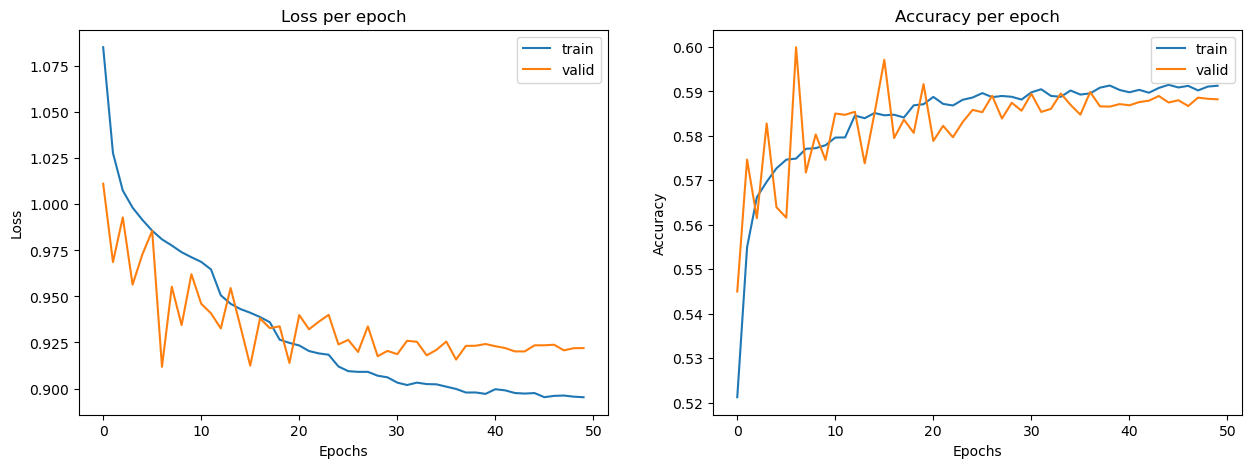

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.58      0.23      3050
           2       0.37      0.44      0.40     17500
           3       0.69      0.45      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35698  1911  2878   5650
1                 168  1780   864    238
2                1483  4849  7715   3453
3               11011  4125  9513  20448



 Accuracy :  59.0
Epoch 1/60


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1416 - sparse_categorical_accuracy: 0.4844 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.5701 - learning_rate: 0.0010
Epoch 2/60
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0387 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.9621 - val_sparse_categorical_accuracy: 0.5771 - learning_rate: 0.0010
Epoch 3/60
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0183 - sparse_categorical_accuracy: 0.5624 - val_loss: 1.0269 - val_sparse_categorical_accuracy: 0.5435 - learning_rate: 0.0010
Epoch 4/60
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9950 - sparse_categorical_accuracy: 0.5679 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.5615 - learning_rate: 0.0010
Epoch 5/60
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9857 - sparse_categorical_accuracy: 0.5747 - val_loss: 1.0024 - val_sparse_categorical_accuracy: 0.5465 - learning_rate: 0.0010
Epoch 6/60
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

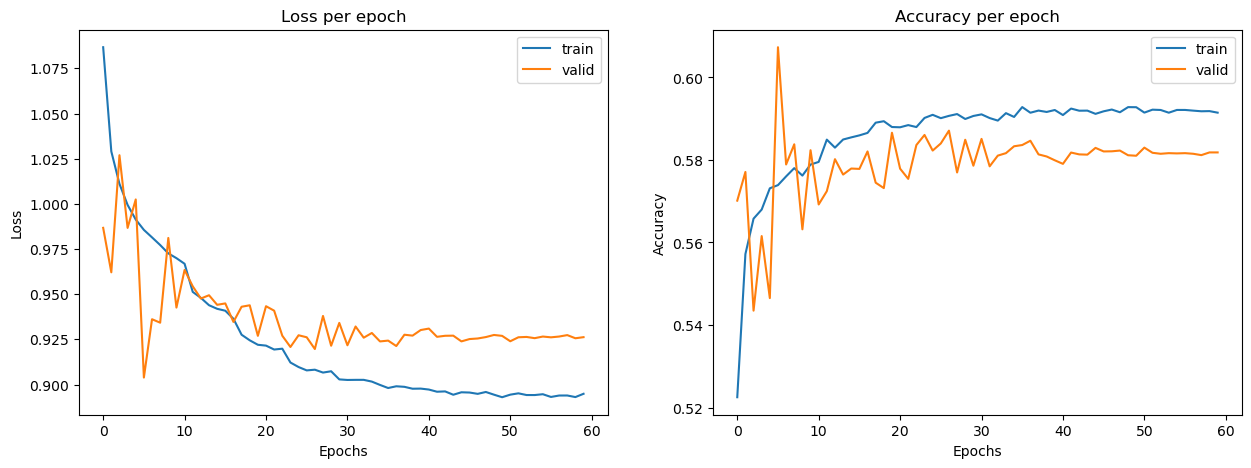

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.13      0.60      0.22      3050
           2       0.36      0.43      0.39     17500
           3       0.69      0.45      0.54     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.58      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35450  2035  2789   5863
1                 157  1815   834    244
2                1415  5288  7548   3249
3               10731  4401  9587  20378



 Accuracy :  57.99999999999999
Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1309 - sparse_categorical_accuracy: 0.4973 - val_loss: 0.9957 - val_sparse_categorical_accuracy: 0.5561 - learning_rate: 0.0010
Epoch 2/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0303 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.5573 - learning_rate: 0.0010
Epoch 3/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 228s 97ms/step - loss: 1.0058 - sparse_categorical_accuracy: 0.5649 - val_loss: 0.9526 - val_sparse_categorical_accuracy: 0.5842 - learning_rate: 0.0010
Epoch 4/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9972 - sparse_categorical_accuracy: 0.5702 - val_loss: 0.9379 - val_sparse_categorical_accuracy: 0.5782 - learning_rate: 0.0010
Epoch 5/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9892 - sparse_categorical_accuracy: 0.5717 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.5876 - learning_rate: 0.0010
Epoch 6/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 253s 1

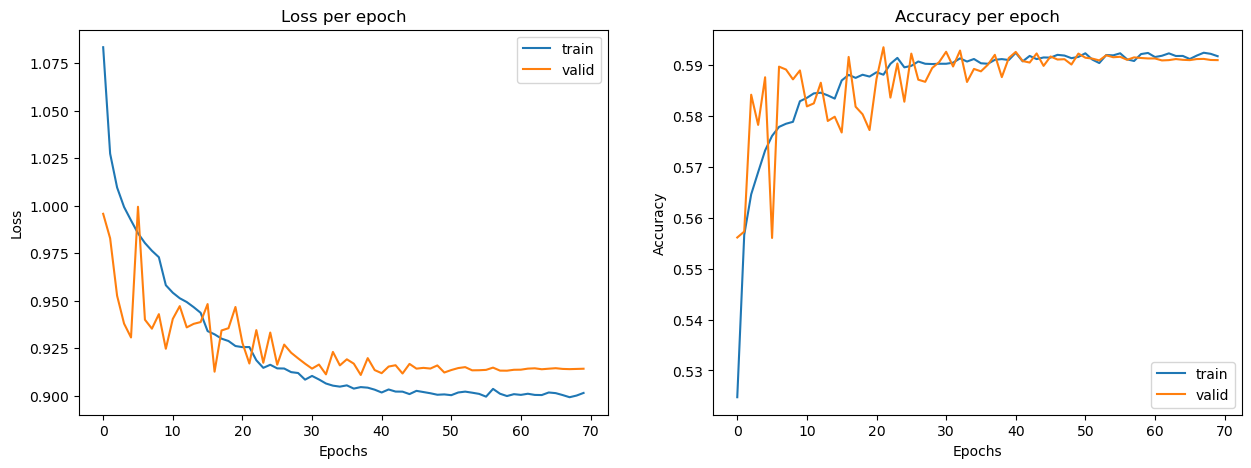

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.60      0.22      3050
           2       0.38      0.43      0.40     17500
           3       0.69      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.57      0.49    111784
weighted avg       0.65      0.59      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35623  2025  2564   5925
1                 161  1835   815    239
2                1485  5216  7456   3343
3               10779  4238  8783  21297



 Accuracy :  59.0
Epoch 1/80


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 991s 420ms/step - loss: 1.1429 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.0025 - val_sparse_categorical_accuracy: 0.5504 - learning_rate: 0.0010
Epoch 2/80
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 938s 398ms/step - loss: 1.0313 - sparse_categorical_accuracy: 0.5536 - val_loss: 1.0134 - val_sparse_categorical_accuracy: 0.5446 - learning_rate: 0.0010
Epoch 3/80
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0095 - sparse_categorical_accuracy: 0.5632 - val_loss: 0.9394 - val_sparse_categorical_accuracy: 0.5880 - learning_rate: 0.0010
Epoch 4/80
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9971 - sparse_categorical_accuracy: 0.5709 - val_loss: 0.9304 - val_sparse_categorical_accuracy: 0.5930 - learning_rate: 0.0010
Epoch 5/80
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9937 - sparse_categorical_accuracy: 0.5753 - val_loss: 0.9378 - val_sparse_categorical_accuracy: 0.5857 - learning_rate: 0.0010
Epoch 6/80
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3

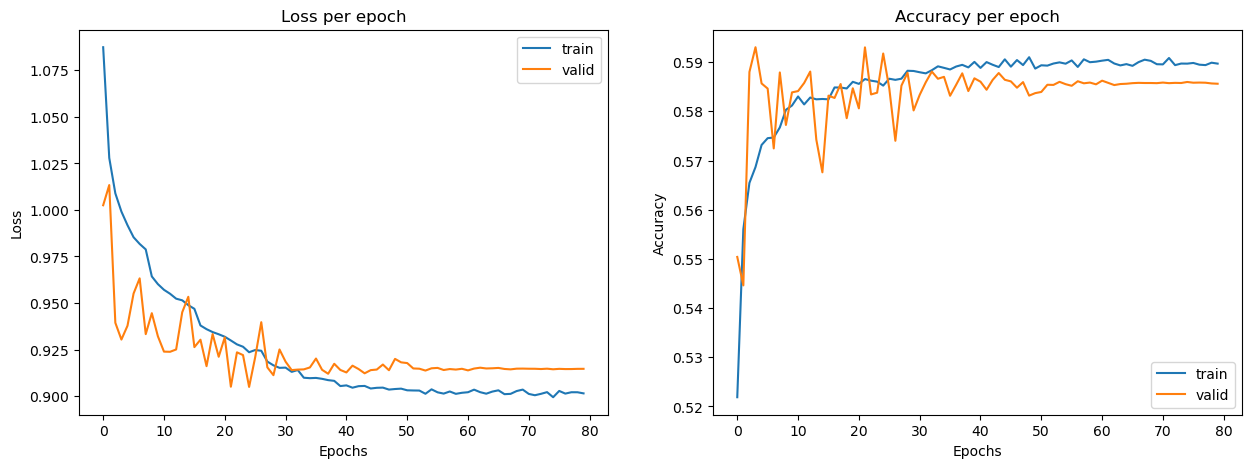

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.61      0.22      3050
           2       0.37      0.41      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35829  1969  2755   5584
1                 170  1856   776    248
2                1504  5243  7159   3594
3               11223  4504  8640  20730



 Accuracy :  59.0
Epoch 1/90


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1425 - sparse_categorical_accuracy: 0.4897 - val_loss: 1.0111 - val_sparse_categorical_accuracy: 0.5493 - learning_rate: 0.0010
Epoch 2/90
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0299 - sparse_categorical_accuracy: 0.5536 - val_loss: 1.0105 - val_sparse_categorical_accuracy: 0.5427 - learning_rate: 0.0010
Epoch 3/90
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0119 - sparse_categorical_accuracy: 0.5606 - val_loss: 0.9308 - val_sparse_categorical_accuracy: 0.5946 - learning_rate: 0.0010
Epoch 4/90
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9999 - sparse_categorical_accuracy: 0.5686 - val_loss: 0.9775 - val_sparse_categorical_accuracy: 0.5692 - learning_rate: 0.0010
Epoch 5/90
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.5710 - val_loss: 0.9588 - val_sparse_categorical_accuracy: 0.5765 - learning_rate: 0.0010
Epoch 6/90
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

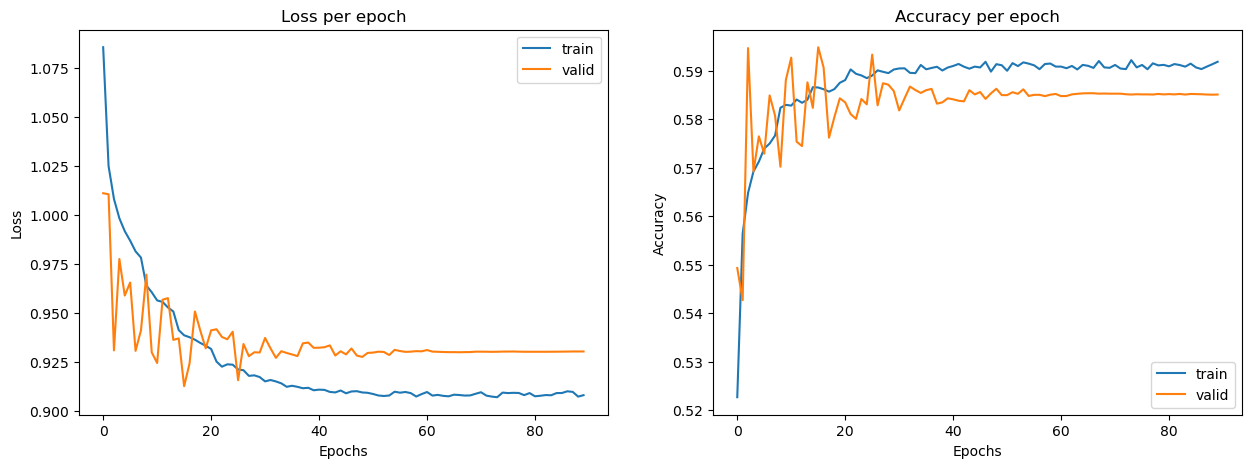

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.13      0.61      0.22      3050
           2       0.37      0.40      0.39     17500
           3       0.69      0.45      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36199  2082  2503   5353
1                 162  1867   776    245
2                1496  5475  6998   3531
3               11491  4667  8536  20403



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.0332 - val_sparse_categorical_accuracy: 0.5394 - learning_rate: 0.0010
Epoch 2/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0348 - sparse_categorical_accuracy: 0.5496 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.5518 - learning_rate: 0.0010
Epoch 3/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0069 - sparse_categorical_accuracy: 0.5678 - val_loss: 0.9402 - val_sparse_categorical_accuracy: 0.5830 - learning_rate: 0.0010
Epoch 4/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9973 - sparse_categorical_accuracy: 0.5720 - val_loss: 0.9004 - val_sparse_categorical_accuracy: 0.6059 - learning_rate: 0.0010
Epoch 5/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9958 - sparse_categorical_accuracy: 0.5709 - val_loss: 0.9675 - val_sparse_categorical_accuracy: 0.5713 - learning_rate: 0.0010
Epoch 6/100
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 2

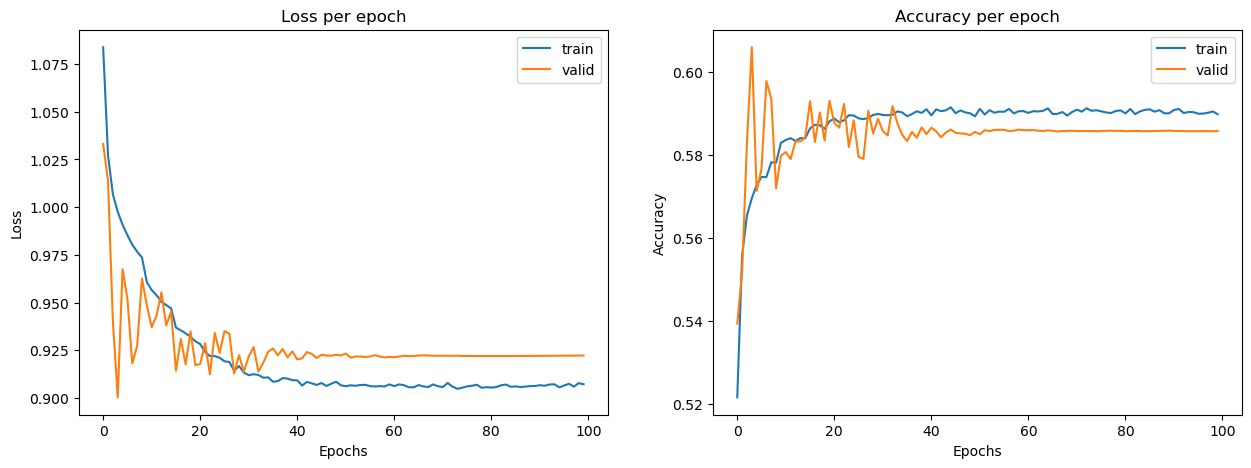

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     46137
           1       0.14      0.61      0.22      3050
           2       0.38      0.41      0.39     17500
           3       0.68      0.47      0.56     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.56      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35627  2125  2478   5907
1                 165  1862   780    243
2                1481  5315  7128   3576
3               10917  4470  8598  21112



 Accuracy :  59.0


In [90]:
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in epochs :
    model6 = Sequential()
    model6.add( Dense(units = 70, activation = "gelu", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 140, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add( Dense(units = 70, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 35, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add(Dense(units = 14, activation = "gelu", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 4, activation = 'softmax'))

    model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history6 = model6.fit(X_train, y_train, epochs = epoch, batch_size = 128, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
    print("\n Modèle avec une epoch de :", epoch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history6.history['loss'], label = 'train')
    plt.plot(history6.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model6.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100) 

Le meilleur nombre d'epoch est 70.

# Meilleur modèle

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.GlorotNormal()

Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.1490 - sparse_categorical_accuracy: 0.4772 - val_loss: 0.9463 - val_sparse_categorical_accuracy: 0.5900 - learning_rate: 0.0010
Epoch 2/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0331 - sparse_categorical_accuracy: 0.5527 - val_loss: 0.9850 - val_sparse_categorical_accuracy: 0.5638 - learning_rate: 0.0010
Epoch 3/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0070 - sparse_categorical_accuracy: 0.5655 - val_loss: 0.9664 - val_sparse_categorical_accuracy: 0.5729 - learning_rate: 0.0010
Epoch 4/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0042 - sparse_categorical_accuracy: 0.5690 - val_loss: 0.9439 - val_sparse_categorical_accuracy: 0.5836 - learning_rate: 0.0010
Epoch 5/70
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.5704 - val_loss: 0.9891 - val_sparse_categorical_accuracy: 0.5724 - learning_rate: 0.0010
Epoch 6/70
2335/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

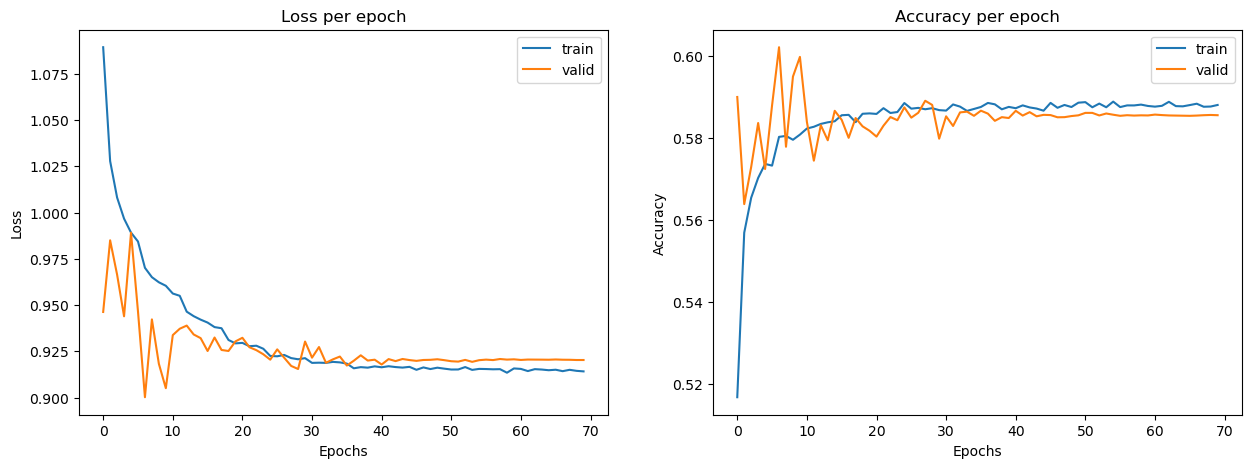

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.14      0.62      0.23      3050
           2       0.37      0.41      0.39     17500
           3       0.69      0.46      0.55     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.57      0.48    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35858  2079  2492   5708
1                 173  1877   762    238
2                1548  5297  7199   3456
3               11071  4306  8828  20892



 Accuracy :  59.0


In [16]:
model6 = Sequential()
model6.add( Dense(units = 70, activation = "gelu", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
model6.add(Dense(units = 140, activation = "gelu", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add( Dense(units = 70, activation = "gelu", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 35, activation = "gelu", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add(Dense(units = 14, activation = "gelu", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 4, activation = 'softmax'))

model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
history6 = model6.fit(X_train, y_train, epochs = 70, batch_size = 128, validation_split = 0.1, callbacks = [reduce_learning_rate], class_weight = weights_dict)
    
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label = 'train')
plt.plot(history6.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()
test_pred = model6.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

In [17]:
print(classification_report_imbalanced(y_test, test_pred_class), '\n\n')

                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.78      0.81      0.76      0.79      0.62     46137
          1       0.14      0.62      0.89      0.23      0.74      0.53      3050
          2       0.37      0.41      0.87      0.39      0.60      0.34     17500
          3       0.69      0.46      0.86      0.55      0.63      0.38     45097

avg / total       0.64      0.59      0.84      0.60      0.69      0.48    111784
 




In [18]:
cr= classification_report(y_test, 
                          test_pred_class,
                          target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],
                          output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv(conf['local_data_path'] + 'DNN_4classes_report' + '.csv')

                precision    recall  f1-score        support
Indemnes         0.737061  0.777207  0.756602   46137.000000
Blessés légers   0.138432  0.615410  0.226022    3050.000000
Blessés graves   0.373373  0.411371  0.391452   17500.000000
Tués             0.689642  0.463268  0.554231   45097.000000
accuracy         0.588868  0.588868  0.588868       0.588868
macro avg        0.484627  0.566814  0.482077  111784.000000
weighted avg     0.644661  0.588868  0.603318  111784.000000


In [19]:
model6.save("../../../data/saved_models/dnn_keras.h5")

In [20]:
fich = conf['local_data_path'] + "/saved_models/dnn_keras.h5"
fich_zip = conf['local_data_path'] + "/saved_models/dnn_keras.zip"
myZip = zipfile.ZipFile(fich_zip, 'w', zipfile.ZIP_DEFLATED)
myZip.write(fich)
myZip.close()